In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline
from scipy.interpolate import interp1d
import datetime


#import data to a pandas dataframe
data = pd.read_csv(r'C:\Users\nadia\OneDrive\Desktop\thesis\data\solar_data.csv')


#add colums to our dataframe
data['kt'] = data['GHIobs']/ data['TOA']
data['h']= np.radians(90 - data['sza'])
data['m']= (np.sin(data['h']) + 0.15 * (np.degrees(data['h']) + 3.885)**(-1.253))**(-1)
data['kt_1']= data['kt']/(1.031 * np.exp(-1.4/(0.9+ 9.4/data['m'])) + 0.1)


#divide dataframe according to weather conditions (ανοιχτό διάστημα προς τα αριστερά)
clear = data[data['GHIraw'].gt(0) & data['kt_1'].between(0.65,10,inclusive='right')] 
intermediate = data[data['GHIraw'].gt(0) & data['kt_1'].between(0.30,0.65,inclusive='right')]  
cloudy = data[data['GHIraw'].gt(0) & data['kt_1'].between(0.00,0.30,inclusive='right')]


data

timestamp     GHIobs  GHIraw      TOA      sza        kt  \
0       2019-01-01T06:58:00Z  64.056280  39.696  250.560  79.7477  0.255652   
1       2019-01-01T06:59:00Z  64.580127  42.480  254.166  79.5986  0.254086   
2       2019-01-01T07:00:00Z  65.055307  45.342  257.760  79.4499  0.252387   
3       2019-01-01T07:01:00Z  65.915272  48.276  261.336  79.3017  0.252224   
4       2019-01-01T07:02:00Z  66.664090  51.288  264.906  79.1538  0.251652   
...                      ...        ...     ...      ...      ...       ...   
446730  2020-12-31T14:10:00Z  54.462491  15.480  262.002  79.2741  0.207871   
446731  2020-12-31T14:11:00Z  52.894380  20.472  258.426  79.4221  0.204679   
446732  2020-12-31T14:12:00Z  53.381819  27.396  254.844  79.5706  0.209469   
446733  2020-12-31T14:13:00Z  56.225214  34.044  251.244  79.7194  0.223787   
446734  2020-12-31T14:14:00Z  60.892028  40.410  247.632  79.8687  0.245897   

               h         m      kt_1  
0       0.178936  5.452219  0.362773  
1       0.181539  5.379213  0.359094  
2       0.184134  5.308312  0.355280  
3       0.186721  5.239476  0.353672  
4       0.189302  5.172529  0.351524  
...          ...       ...       ...  
446730  0.187202  5.226852  0.291269  
446731  0.184619  5.295263  0.287910  
446732  0.182027  5.365719  0.295814  
446733  0.179430  5.438211  0.317310  
446734  0.176825  5.512927  0.350096  

[446735 rows x 9 columns]

### functions 

In [2]:
# scatter plot function 
def scatter(raw,obs,z,cond):
    
    plt.figure(figsize=(10,10))
    plt.plot(obs,raw,"o",color=z,markersize=1)
    plt.plot([0,1200],[0,1200],color='black', markersize=0.05, linestyle='--', label = "y=x")
    plt.xlabel("obs GHI (Wm^(-2))")
    plt.ylabel("mod GHI (Wm^(-2))")
    plt.ylim(bottom=0, top=max(raw))
    plt.xlim(left=0, right=max(obs))
    
    model = LinearRegression().fit(raw.values.reshape(-1,1), obs.values.reshape((-1, 1))) #r
    yn = (model.coef_[0][0])*obs + (model.intercept_)
    plt.plot(yn, obs,'-', color= 'blue', label ="GHIraw = aGHIobs+b") #r
    plt.xlim(left=0, right=max(obs))
    plt.ylim(bottom=0)
    plt.legend()
    
    print('for', cond ,'weather conditions')
    print('*slope (a) is:', model.coef_)
    print("*intercept(b) is",model.intercept_)
    
    return (model.coef_,model.intercept_)

In [3]:
# MBE function 
def MBE(name,raw,obs,c):
    
    data[name]= obs-raw
    sum_ = data[name].sum()
    n = len(data[name])
    MBE_= sum_ / n
    print("the MBE index for the", c, "conditions is:",MBE_)
    
    return MBE_


In [4]:
# RMSE function
def RMSE(name,raw,obs,c):
    
    data[name] = (raw-obs)**2
    sum_=data[name].sum()
    n = len(data[name])
    RMSE_=(sum_/n)**0.5
    print("the RMSE index for the",c, "conditions is:", RMSE_)
    
    return RMSE_

In [5]:
# R function
def R(raw, obs, c):
    
    n=len(raw)
    xmean = raw.sum()/n
    ymean = obs.sum()/n
    nu= ((raw-xmean)*(obs-ymean)).sum()
    den= (((raw-xmean)**2).sum() * ((obs-ymean)**2).sum())**0.5
    R_ = nu / den
    print("the R index for the",c, "conditions is:", R_)
    
    return R_

In [6]:
def ener(month,obs,eqm,lin):
    plt.figure(figsize=(10,10))
    plt.plot(month, obs, label="observed")
    plt.plot(month, eqm, label="eqm")
    plt.plot(month, lin, label="linear")
    plt.ylabel('sum for each month(kWh/m2)')
    plt.xlabel('months')
    plt.ylim(top=260)
    plt.legend()

In [7]:
def meanrad(month,obs,eqm,lin,limit):
    plt.figure(figsize=(10,10))
    plt.plot(month, obs, label="observed")
    plt.plot(month, eqm, label="eqm")
    plt.plot(month, lin, label="linear")
    plt.ylim(bottom=0, top=limit)
    plt.ylabel('mean radiation (W/m2)')
    plt.xlabel('months')
    plt.legend()

In [8]:
def bar(obs,eqm,lin,t,num,title):

    x = np.arange(12)  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(8,8))
    b1 = ax.bar(x - width, obs, width, label='obs')
    b2 = ax.bar(x + width, eqm, width, label='eqm')
    b3 = ax.bar(x, lin, width, label='linear')
    
    ax.set_ylabel(t)
    ax.set_xlabel('months')
    
    fig.canvas.draw()

    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[1] = 'Jan'
    labels[2] = 'Mar'
    labels[3] = 'May'
    labels[4] = 'Jul'
    labels[5] = 'Sep'
    labels[6] = 'Nov'
    
    ax.set_xticklabels(labels)
    
    plt.ylim(top=num)
    plt.title(title)
    
    ax.legend()

    fig.tight_layout()

    plt.show()

In [93]:
# train mod plot function for a*,b*
def trainmod(raw,obs,z,cond):
    
    plt.figure(figsize=(10,10))
    plt.plot(obs,raw,"o",color=z,markersize=1)
    plt.plot([0,1200],[0,1200],color='black', markersize=0.05,linestyle='--', label = "y=x")
    plt.xlabel("mod GHI (Wm^(-2))")
    plt.ylabel("corr mod GHI (Wm^(-2))")
    plt.ylim(bottom=0, top=max(raw))
    plt.xlim(left=0, right=max(obs))
    
    model = LinearRegression().fit(obs.values.reshape(-1,1), raw.values.reshape((-1, 1)))
    yn = (model.coef_[0][0])*obs + (model.intercept_)
    plt.plot(obs, yn,'-', color= 'blue', label ="GHImodcor = a*GHImod + b*")
    plt.xlim(left=0, right=max(obs))
    plt.ylim(bottom=0)
    plt.legend()
    
    print('for', cond ,'weather conditions')
    print('*slope (a) is:', model.coef_)
    print("*intercept(b) is",model.intercept_)
    
    return (model.coef_,model.intercept_)

# Data Visualization and Errors

for clear weather conditions
*slope (a) is: [[0.98148241]]
*intercept(b) is [2.86769278]
the MBE index for the clear conditions is: 5.691368313023689
the RMSE index for the clear conditions is: 48.89818975231034
the R index for the clear conditions is: 0.9729398936115145


0.9729398936115145

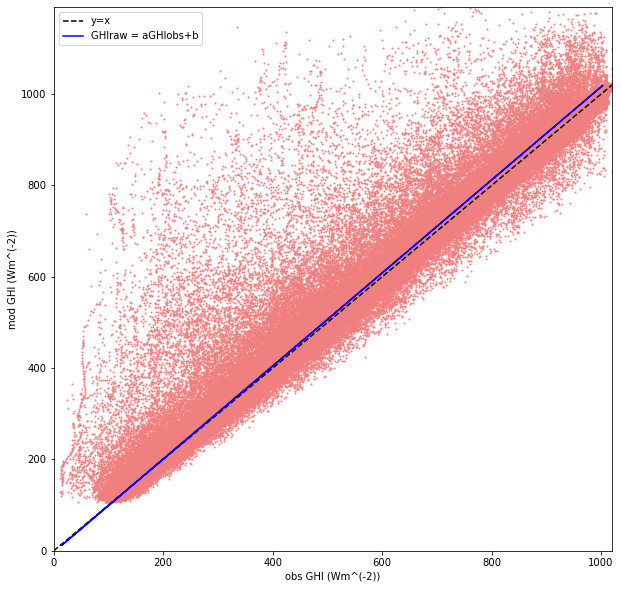

In [10]:
#clear weather conditions 

p1,p11 = scatter(clear['GHIobs'],clear['GHIraw'],'lightcoral','clear')
MBE('clr',clear['GHIraw'],clear['GHIobs'],'clear')
RMSE('clr2',clear['GHIraw'],clear['GHIobs'],'clear')
R(clear['GHIraw'],clear['GHIobs'],'clear')

for intermediate weather conditions
*slope (a) is: [[1.14972483]]
*intercept(b) is [28.24778304]
the MBE index for the intermediate conditions is: -10.419590634533211
the RMSE index for the intermediate conditions is: 56.62689786017935
the R index for the intermediate conditions is: 0.8142533897166538


0.8142533897166538

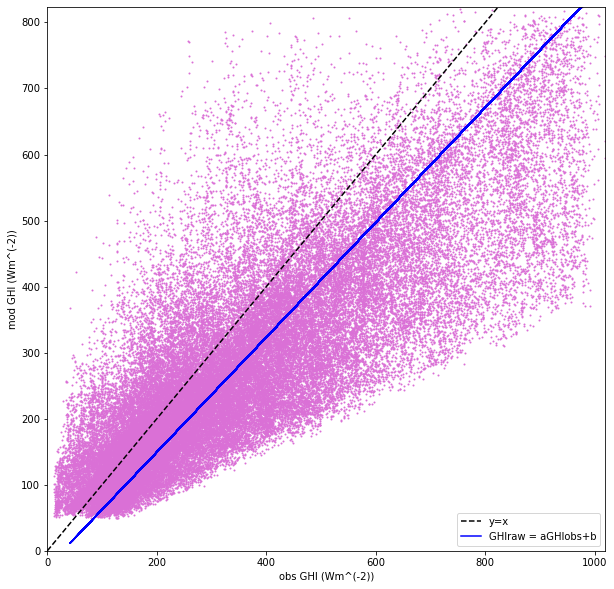

In [11]:
#intermediate weather conditions 

p2,p22 = scatter(intermediate['GHIobs'],intermediate['GHIraw'],'orchid','intermediate')
MBE('int',intermediate['GHIraw'],intermediate['GHIobs'],'intermediate')
RMSE('int2',intermediate['GHIraw'],intermediate['GHIobs'],'intermediate')
R(intermediate['GHIraw'],intermediate['GHIobs'],'intermediate')

for cloudy weather conditions
*slope (a) is: [[1.58052854]]
*intercept(b) is [33.75665189]
the MBE index for the cloudy conditions is: -10.666448554292954
the RMSE index for the cloudy conditions is: 55.20423858551945
the R index for the cloudy conditions is: 0.6800137826364004


0.6800137826364004

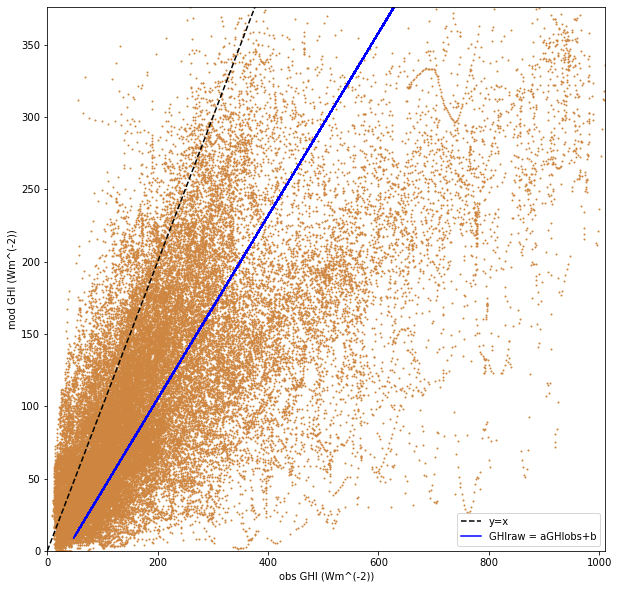

In [12]:
#cloudy weather conditions

p3,p33 = scatter(cloudy['GHIobs'],cloudy['GHIraw'],'peru','cloudy')
MBE('cld',cloudy['GHIraw'],cloudy['GHIobs'],'cloudy')
RMSE('cld2',cloudy['GHIraw'],cloudy['GHIobs'],'cloudy')
R(cloudy['GHIraw'],cloudy['GHIobs'],'cloudy')

In [13]:
#is the kt_1 index okay for the cloudy conditions?
print(cloudy[['timestamp','GHIobs','GHIraw','kt','kt_1']].head(15))

                timestamp     GHIobs   GHIraw        kt      kt_1
14   2019-01-01T07:12:00Z  66.571981   90.000  0.221942  0.299512
438  2019-01-02T06:58:00Z  39.191831  152.730  0.156503  0.222116
877  2019-01-03T06:58:00Z   1.241005   22.482  0.004956  0.007033
878  2019-01-03T06:59:00Z   1.278386   22.242  0.005032  0.007113
889  2019-01-03T07:10:00Z   2.055013   17.874  0.007011  0.009522
891  2019-01-03T07:12:00Z   3.136635   19.344  0.010454  0.014107
892  2019-01-03T07:13:00Z   4.004433   20.190  0.013194  0.017749
893  2019-01-03T07:14:00Z   4.964095   21.054  0.016173  0.021689
894  2019-01-03T07:15:00Z   5.608336   21.936  0.018070  0.024160
895  2019-01-03T07:16:00Z   5.865494   22.830  0.018693  0.024918
896  2019-01-03T07:17:00Z   5.750725   23.742  0.018130  0.024098
897  2019-01-03T07:18:00Z   5.305305   24.672  0.016549  0.021933
898  2019-01-03T07:19:00Z   5.343344   25.614  0.016493  0.021799
899  2019-01-03T07:20:00Z   5.981622   26.574  0.018274  0.024085
900  2019-

# Correction of mod values

In [14]:
#by now we have divided our dataframe to 3 different ones according to the weather conditions
clear 

timestamp      GHIobs   GHIraw      TOA      sza        kt  \
75      2019-01-01T08:13:00Z  280.098494  101.304  485.058  69.8456  0.577454   
76      2019-01-01T08:14:00Z  303.008111  102.042  487.638  69.7337  0.621379   
77      2019-01-01T08:15:00Z  322.162920  102.780  490.200  69.6224  0.657207   
78      2019-01-01T08:16:00Z  331.547972  103.518  492.750  69.5117  0.672852   
79      2019-01-01T08:17:00Z  338.123407  104.250  495.282  69.4016  0.682689   
...                      ...         ...      ...      ...      ...       ...   
446662  2020-12-31T13:02:00Z  372.732793  239.304  474.810  70.2890  0.785015   
446679  2020-12-31T13:19:00Z  291.647972  221.760  427.662  72.3149  0.681959   
446680  2020-12-31T13:20:00Z  261.273001  221.688  424.758  72.4391  0.615110   
446690  2020-12-31T13:30:00Z  288.905678  207.744  394.884  73.7099  0.731622   
446693  2020-12-31T13:33:00Z  304.282735  199.764  385.650  74.1011  0.789013   

               h         m      kt_1  
75      0.351761  2.879004  0.690174  
76      0.353714  2.864025  0.741777  
77      0.355656  2.849290  0.783612  
78      0.357588  2.834793  0.801324  
79      0.359510  2.820529  0.812097  
...          ...       ...       ...  
446662  0.344022  2.940026  0.942854  
446679  0.308663  3.257514  0.839566  
446680  0.306496  3.279336  0.758520  
446690  0.284316  3.521406  0.918552  
446693  0.277488  3.603555  0.996514  

[315722 rows x 9 columns]

# First method: LINEAR CORRECTION


In [15]:
# GHImod = aGHIobs + β : already calculated above (GHImod=GHIraw)
# GHImod,cor = GHImod - [(a-1)GHIobs +b]

GHIcclr = clear['GHIraw'] - ((p1[0][0] - 1)*clear['GHIobs'] +  p11)
GHIcint = intermediate['GHIraw'] - ((p2[0][0] - 1)*intermediate['GHIobs'] +  p22)
GHIccld = cloudy['GHIraw'] - ((p3[0][0] - 1)*cloudy['GHIobs'] +  p33)


In [16]:
#GHIcclr[GHIcclr<0] = 0
#GHIcint[GHIcint<0] = 0
#GHIccld[GHIccld<0] = 0

### GHImod,cor = a'GHImod + b' : προσδιορισμός των α', β'

for clear weather conditions
*slope (a) is: [[1.]]
*intercept(b) is [-4.32009983e-12]
the MBE index for the clear conditions is: -1.3864279537250589e-13
the RMSE index for the clear conditions is: 48.27515972538156
the R index for the clear conditions is: 0.9738942545309546


0.9738942545309546

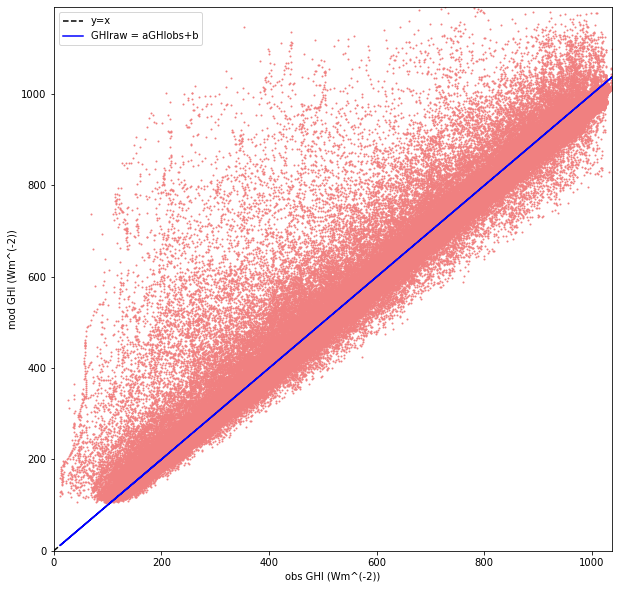

In [17]:
#corrected clear conditions

scatter(clear['GHIobs'],GHIcclr,'lightcoral','clear')
MBE('cclr', GHIcclr, clear['GHIobs'], 'clear')
RMSE('cclr2',GHIcclr,clear['GHIobs'],'clear')
R(GHIcclr,clear['GHIobs'],'clear')

for intermediate weather conditions
*slope (a) is: [[1.]]
*intercept(b) is [-5.68434189e-14]
the MBE index for the intermediate conditions is: 1.1742902257101525e-14
the RMSE index for the intermediate conditions is: 48.9246364835566
the R index for the intermediate conditions is: 0.7733895376694554


0.7733895376694554

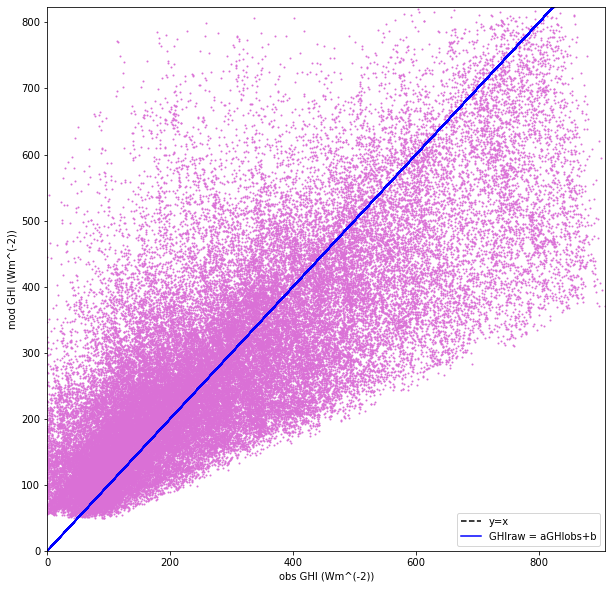

In [18]:
#corrected intermediate conditions

scatter(intermediate['GHIobs'],GHIcint,'orchid','intermediate')
MBE('cint', GHIcint, intermediate['GHIobs'],'intermediate')
RMSE('cint2',GHIcint,intermediate['GHIobs'],'intermediate')
R(GHIcint,intermediate['GHIobs'],'intermediate')

for cloudy weather conditions
*slope (a) is: [[1.]]
*intercept(b) is [9.9475983e-14]
the MBE index for the cloudy conditions is: 2.9642277542198024e-15
the RMSE index for the cloudy conditions is: 42.239468929617026
the R index for the cloudy conditions is: 0.5061029424612975


0.5061029424612975

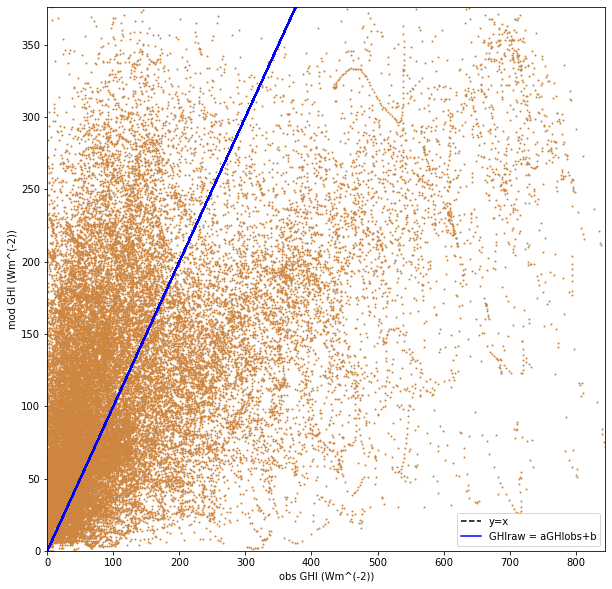

In [19]:
#corrected cloudy conditions

scatter(cloudy['GHIobs'],GHIccld,'peru','cloudy')
MBE('ccld', GHIccld, cloudy['GHIobs'], 'cloudy')
RMSE('ccld2',GHIccld,cloudy['GHIobs'],'cloudy')
R(GHIccld,cloudy['GHIobs'],'cloudy')

### Σύγκριση αρχικών data με διορθωμένα data για τις cloudy συνθήκες

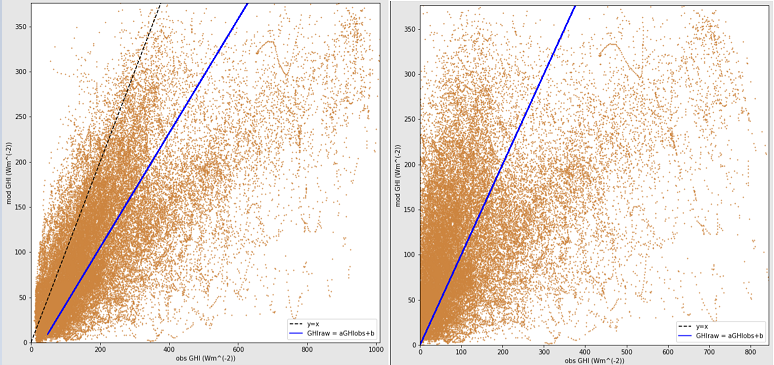

In [20]:
data.head(100)

timestamp      GHIobs   GHIraw      TOA      sza        kt  \
0   2019-01-01T06:58:00Z   64.056280   39.696  250.560  79.7477  0.255652   
1   2019-01-01T06:59:00Z   64.580127   42.480  254.166  79.5986  0.254086   
2   2019-01-01T07:00:00Z   65.055307   45.342  257.760  79.4499  0.252387   
3   2019-01-01T07:01:00Z   65.915272   48.276  261.336  79.3017  0.252224   
4   2019-01-01T07:02:00Z   66.664090   51.288  264.906  79.1538  0.251652   
..                   ...         ...      ...      ...      ...       ...   
95  2019-01-01T08:33:00Z  423.028853  176.268  533.622  67.7255  0.792750   
96  2019-01-01T08:34:00Z  421.308922  185.010  535.878  67.6262  0.786203   
97  2019-01-01T08:35:00Z  420.132445  193.818  538.116  67.5276  0.780747   
98  2019-01-01T08:36:00Z  419.727926  202.698  540.336  67.4296  0.776791   
99  2019-01-01T08:37:00Z  421.659328  211.650  542.544  67.3324  0.777189   

           h         m      kt_1         clr  ...        int        int2  cld  \
0   0.178936  5.452219  0.362773         NaN  ...  24.360280  593.423262  NaN   
1   0.181539  5.379213  0.359094         NaN  ...  22.100127  488.415634  NaN   
2   0.184134  5.308312  0.355280         NaN  ...  19.713307  388.614476  NaN   
3   0.186721  5.239476  0.353672         NaN  ...  17.639272  311.143927  NaN   
4   0.189302  5.172529  0.351524         NaN  ...  15.376090  236.424155  NaN   
..       ...       ...       ...         ...  ...        ...         ...  ...   
95  0.388763  2.620854  0.927580  246.760853  ...        NaN         NaN  NaN   
96  0.390496  2.609968  0.919077  236.298922  ...        NaN         NaN  NaN   
97  0.392217  2.599256  0.911876  226.314445  ...        NaN         NaN  NaN   
98  0.393928  2.588702  0.906447  217.029926  ...        NaN         NaN  NaN   
99  0.395624  2.578326  0.906117  210.009328  ...        NaN         NaN  NaN   

    cld2        cclr         cclr2       cint        cint2  ccld  ccld2  
0    NaN         NaN           NaN  62.198879  3868.700592   NaN    NaN  
1    NaN         NaN           NaN  60.017159  3602.059411   NaN    NaN  
2    NaN         NaN           NaN  57.701485  3329.461382   NaN    NaN  
3    NaN         NaN           NaN  55.756208  3108.754785   NaN    NaN  
4    NaN         NaN           NaN  53.605143  2873.511380   NaN    NaN  
..   ...         ...           ...        ...          ...   ...    ...  
95   NaN  241.795072  58464.856641        NaN          NaN   NaN    NaN  
96   NaN  231.364990  53529.758630        NaN          NaN   NaN    NaN  
97   NaN  221.402298  49018.977644        NaN          NaN   NaN    NaN  
98   NaN  212.125270  44997.130083        NaN          NaN   NaN    NaN  
99   NaN  205.068907  42053.256604        NaN          NaN   NaN    NaN  

[100 rows x 21 columns]

   # Second method: EQM (empirical quantile mapping)

In [21]:
num = list(np.arange(0,100,0.5))

In [22]:
#calculating the percentiles for the module and the observed values for all weather conditions

clobper = np.percentile(clear['GHIobs'],num)
clrawper = np.percentile(clear['GHIraw'],num)

inobper = np.percentile(intermediate['GHIobs'],num)
inrawper = np.percentile(intermediate['GHIraw'],num)

cdobper = np.percentile(cloudy['GHIobs'],num)
cdrawper = np.percentile(cloudy['GHIraw'],num)

### initial visualization of the data

In [23]:
#plot2 function for the percentiles of mod and obs values
def percent(obper,rawper):
    plt.figure(figsize=(10,10))
    plt.ylabel("percentile (100%)")
    plt.xlabel("GHI (W/m^2)")
    plt.plot(obper, num, color='red', label = "obs")
    plt.plot(rawper, num,color='pink',label = "mod")
    plt.ylim(bottom=0, top=100)
    plt.xlim(left=0, right=1000)
    plt.legend()
    plt.show()

for the clear weather conditions


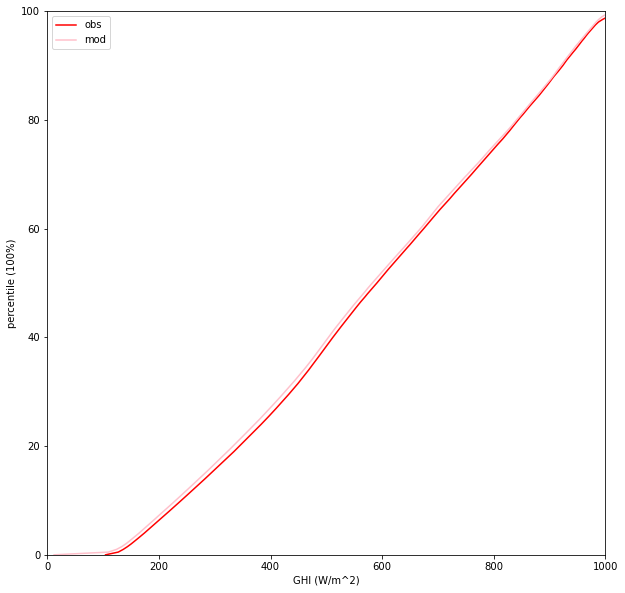

In [24]:
print("for the clear weather conditions")
percent(clobper,clrawper)

for the intermediate weather conditions


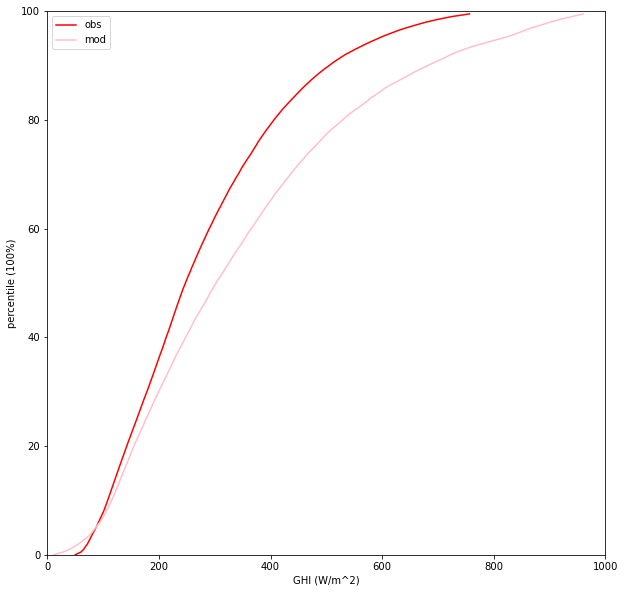

In [25]:
print("for the intermediate weather conditions")
percent(inobper,inrawper)

for the cloudy weather conditions


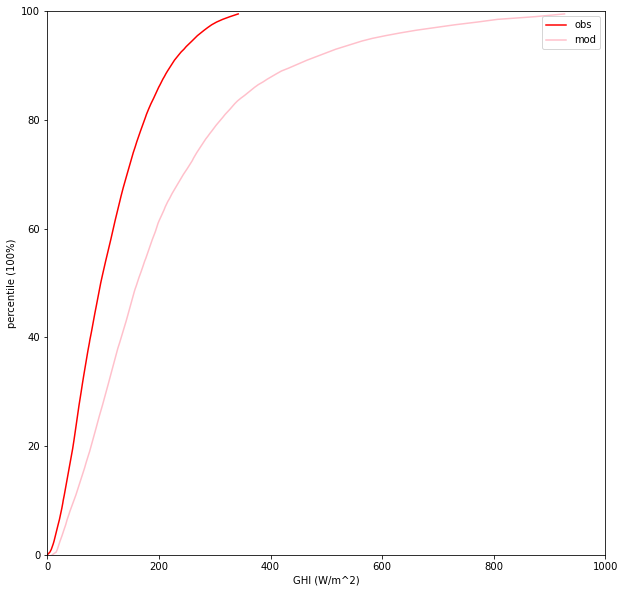

In [26]:
print("for the cloudy weather conditions")
percent(cdobper,cdrawper)

In [27]:
#interpolation function

def interp(rawper,obper,obvalues):
    
    interpolation = interp1d(rawper, obper, 'linear', fill_value="extrapolate")
    
    plt.figure(figsize=(10,10))
    interper=np.percentile(interpolation(obvalues),num)
    
    plt.xlabel("Wm^(-2)")
    plt.ylabel("%")
    
    plt.plot(obper,num,label="obs percentile",color="red")
    plt.plot(interper,num,label="interp percentile",color="pink")
    
    plt.ylim(bottom=0, top=100)
    plt.xlim(left=0, right=1000)
    plt.legend()   
    
    return(interpolation(obvalues))

the MBE index for the clear conditions is: 0.0863019177454904
the RMSE index for the clear conditions is: 48.01088738252367
the R index for the clear conditions is: 0.9731030002399746


0.9731030002399746

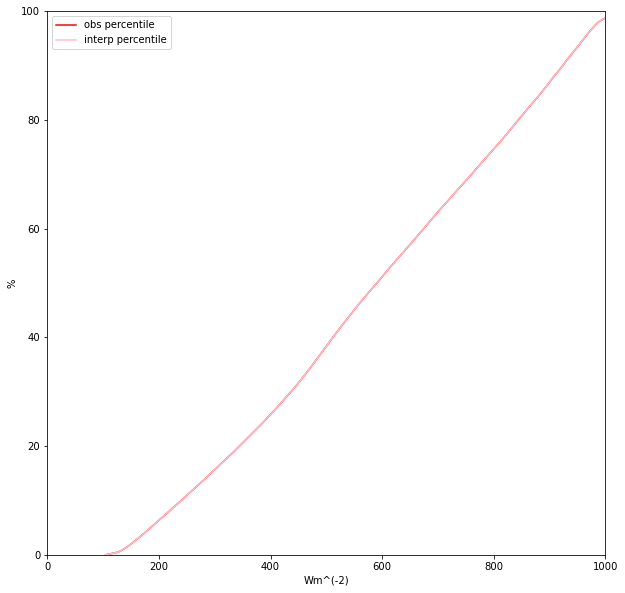

In [28]:
#clear weather conditions

nef1 = interp(clrawper,clobper,clear["GHIraw"])

MBE("clr2", nef1, clear["GHIobs"], 'clear')
RMSE("clr2", nef1, clear["GHIobs"], 'clear')
R(nef1, clear["GHIobs"], 'clear')

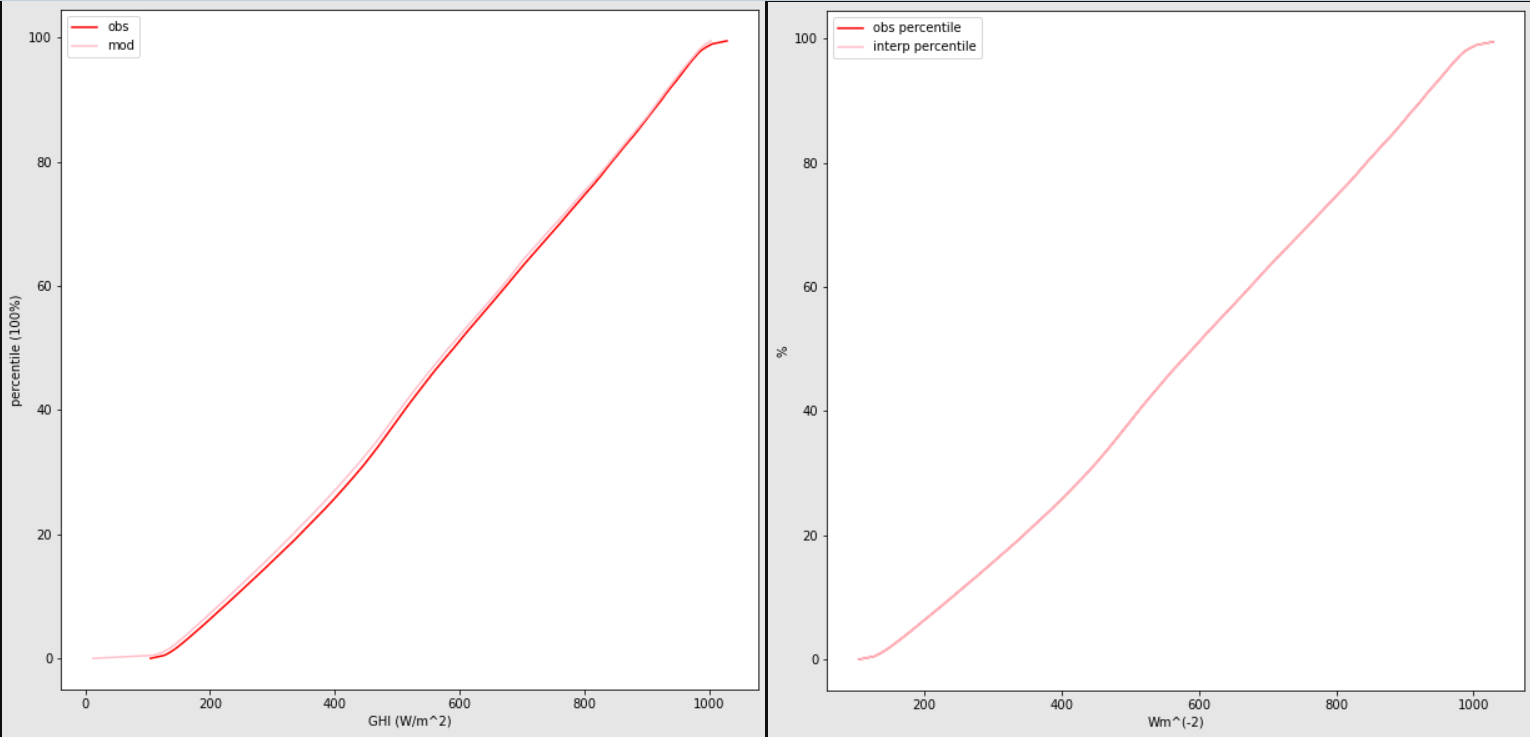

the MBE index for the intermediate conditions is: 0.002954435283542714
the RMSE index for the intermediate conditions is: 36.46901737009891
the R index for the intermediate conditions is: 0.8133093013259846


0.8133093013259846

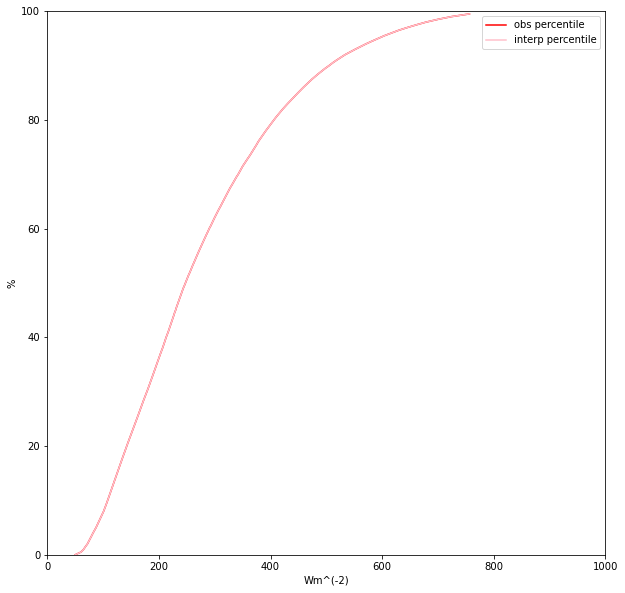

In [29]:
#intermediate weather conditions

nef2 = interp(inrawper,inobper,intermediate["GHIraw"])

MBE("int2", nef2, intermediate["GHIobs"], 'intermediate')
RMSE("int2", nef2, intermediate["GHIobs"], 'intermediate')
R(nef2, intermediate["GHIobs"], 'intermediate')

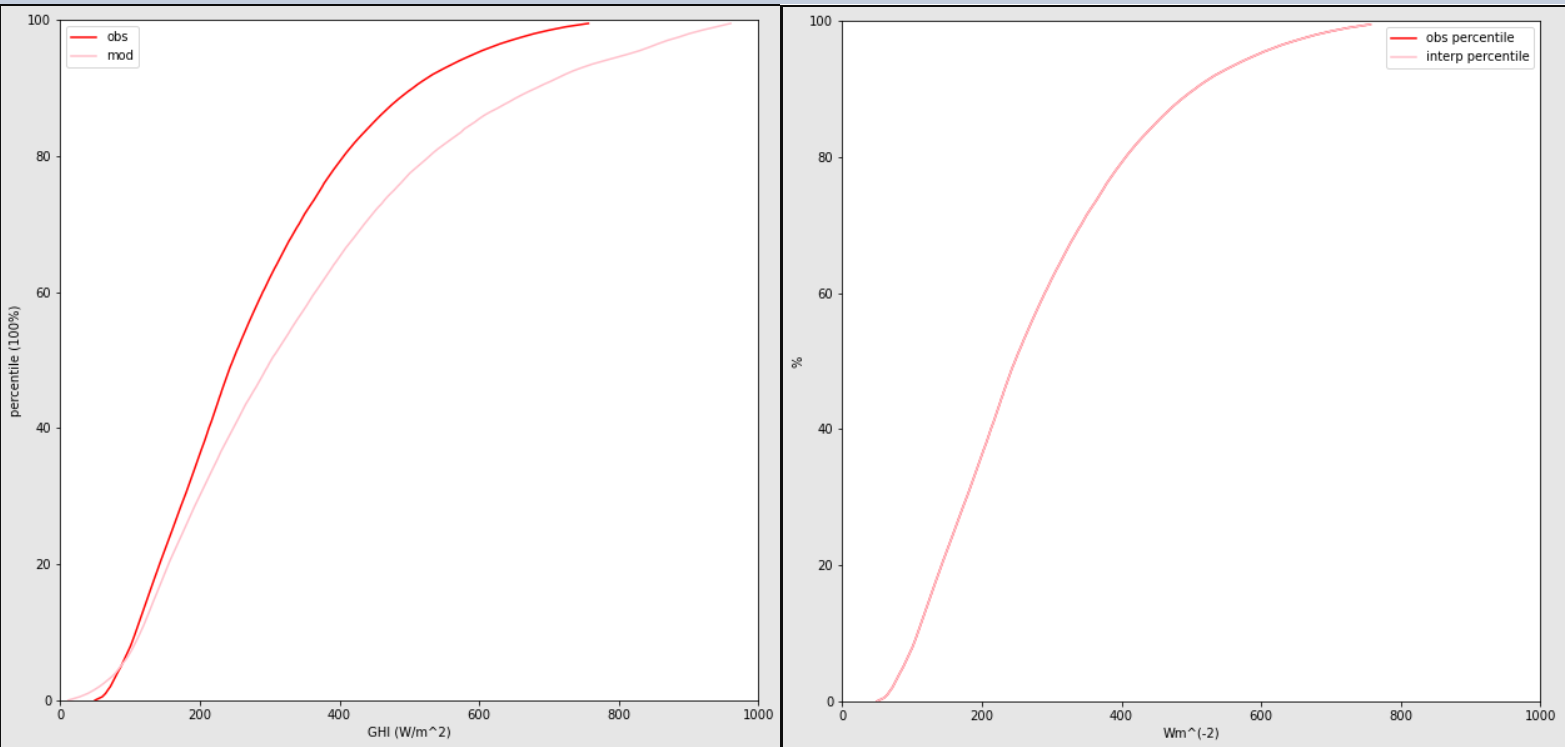

the MBE index for the cloudy conditions is: 0.001335559449314579
the RMSE index for the cloudy conditions is: 18.870774672486675
the R index for the cloudy conditions is: 0.7099242443771292


0.7099242443771292

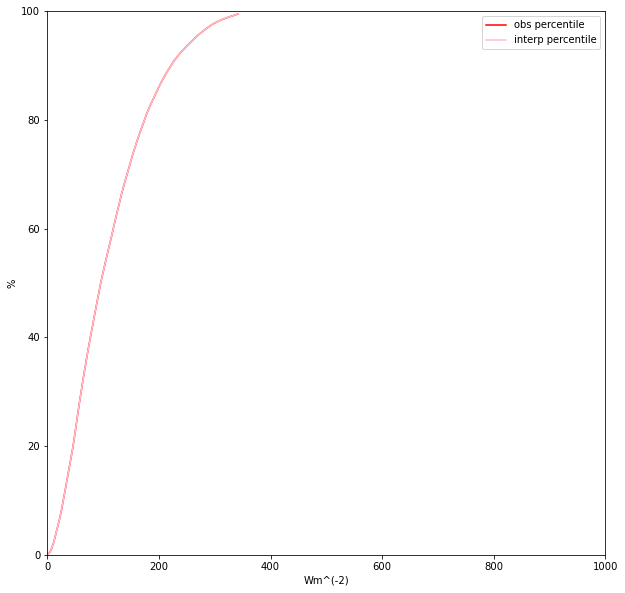

In [30]:
#cloudy weather conditions

nef3 = interp(cdrawper,cdobper,cloudy["GHIraw"])

MBE("cld2", nef3, cloudy["GHIobs"], 'cloudy')
RMSE("cld2", nef3, cloudy["GHIobs"], 'cloudy')
R(nef3, cloudy["GHIobs"], 'cloudy')

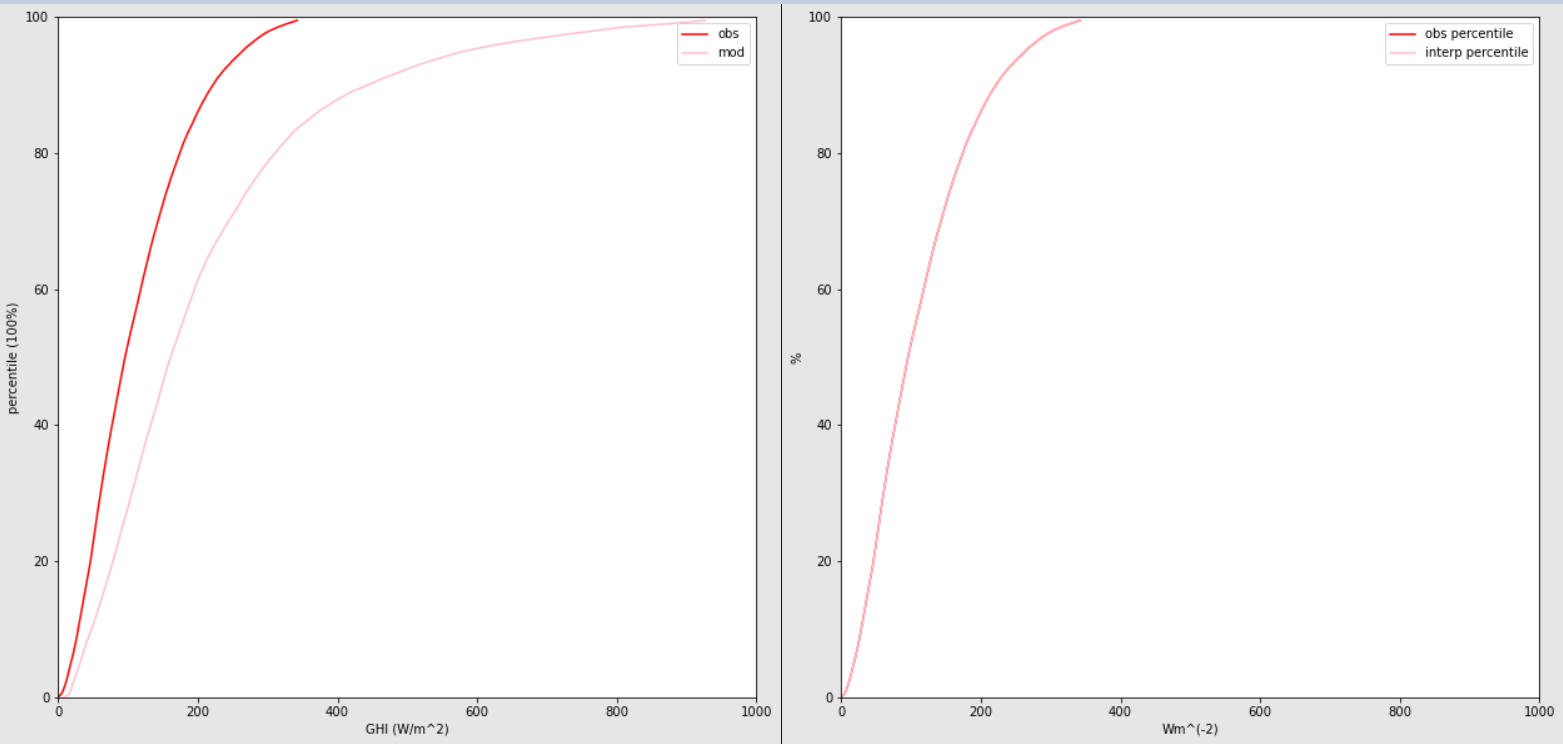

# APPLICATION OF DATA CORRECTION

In [31]:
dt = pd.read_csv(r'C:\Users\nadia\OneDrive\Desktop\thesis\data\Solar_data_2015_2019_1min.csv',  parse_dates=["timestamp"])
dt

timestamp  GHIobs  GHIraw  TOA      zen
0       2015-01-01 00:00:00+00:00     0.0     0.0  0.0  156.554
1       2015-01-01 00:01:00+00:00     0.0     0.0  0.0  156.392
2       2015-01-01 00:02:00+00:00     0.0     0.0  0.0  156.229
3       2015-01-01 00:03:00+00:00     0.0     0.0  0.0  156.066
4       2015-01-01 00:04:00+00:00     0.0     0.0  0.0  155.902
...                           ...     ...     ...  ...      ...
2103835 2018-12-31 23:55:00+00:00     0.0     0.0  0.0  157.351
2103836 2018-12-31 23:56:00+00:00     0.0     0.0  0.0  157.193
2103837 2018-12-31 23:57:00+00:00     0.0     0.0  0.0  157.034
2103838 2018-12-31 23:58:00+00:00     0.0     0.0  0.0  156.875
2103839 2018-12-31 23:59:00+00:00     0.0     0.0  0.0  156.714

[2103840 rows x 5 columns]

In [32]:
#add colums to our dataframe
dt['kt'] = dt['GHIobs']/ dt['TOA']
dt['h']= np.radians(90 - dt['zen'])
dt['m']= (np.sin(dt['h']) + 0.15 * (np.degrees(dt['h']) + 3.885)**(-1.253))**(-1)
dt['kt_1']= dt['kt']/(1.031 * np.exp(-1.4/(0.9+ 9.4/dt['m'])) + 0.1)
dt['month'] = dt['timestamp'].dt.month
dt['hour'] = dt['timestamp'].dt.hour
dt['year'] = dt['timestamp'].dt.year


#divide dataframe according to weather conditions (ανοιχτό διάστημα προς τα αριστερά)
clear1 = dt[dt['GHIraw'].gt(0) & dt['kt_1'].between(0.65,10,inclusive='right')] 
intermediate1 = dt[dt['GHIraw'].gt(0) & dt['kt_1'].between(0.30,0.65,inclusive='right')]  
cloudy1 = dt[dt['GHIraw'].gt(0) & dt['kt_1'].between(0.00,0.30,inclusive='right')]

In [33]:
clear1

timestamp      GHIobs   GHIraw      TOA     zen  \
358     2015-01-01 05:58:00+00:00    4.715679    4.044   16.356  89.504   
430     2015-01-01 07:10:00+00:00  157.404983  180.636  293.040  78.131   
433     2015-01-01 07:13:00+00:00  192.873812  188.934  303.390  77.698   
461     2015-01-01 07:41:00+00:00  264.970104  263.910  394.458  73.859   
473     2015-01-01 07:53:00+00:00  346.546813  294.120  430.206  72.331   
...                           ...         ...      ...      ...     ...   
2101865 2018-12-30 15:05:00+00:00   22.321900    9.666   45.486  87.979   
2101866 2018-12-30 15:06:00+00:00   20.758401    8.244   41.388  88.145   
2101867 2018-12-30 15:07:00+00:00   19.185713    6.942   37.284  88.312   
2101868 2018-12-30 15:08:00+00:00   17.272908    5.754   33.174  88.479   
2102755 2018-12-31 05:55:00+00:00    1.341890    0.324    4.584  89.983   

               kt         h          m      kt_1  month  hour  year  
358      0.288315  0.008657  31.038488  0.683299      1     5  2015  
430      0.537145  0.207153   4.752523  0.731951      1     7  2015  
433      0.635729  0.214710   4.594618  0.857924      1     7  2015  
461      0.671732  0.281714   3.552257  0.845253      1     7  2015  
473      0.805537  0.308382   3.260326  0.991915      1     7  2015  
...           ...       ...        ...       ...    ...   ...   ...  
2101865  0.490742  0.035273  19.428333  1.033408     12    15  2018  
2101866  0.501556  0.032376  20.339675  1.069667     12    15  2018  
2101867  0.514583  0.029461  21.328937  1.111704     12    15  2018  
2101868  0.520676  0.026546  22.397269  1.139605     12    15  2018  
2102755  0.292733  0.000297  36.315064  0.717437     12     5  2018  

[662016 rows x 12 columns]

### Visualisation and Errors

for clear weather conditions
*slope (a) is: [[0.98767487]]
*intercept(b) is [0.35352432]
the MBE index for the clear conditions is: 2.0046792163548863
the RMSE index for the clear conditions is: 29.630694712208793
the R index for the clear conditions is: 0.9850517023125714


0.9850517023125714

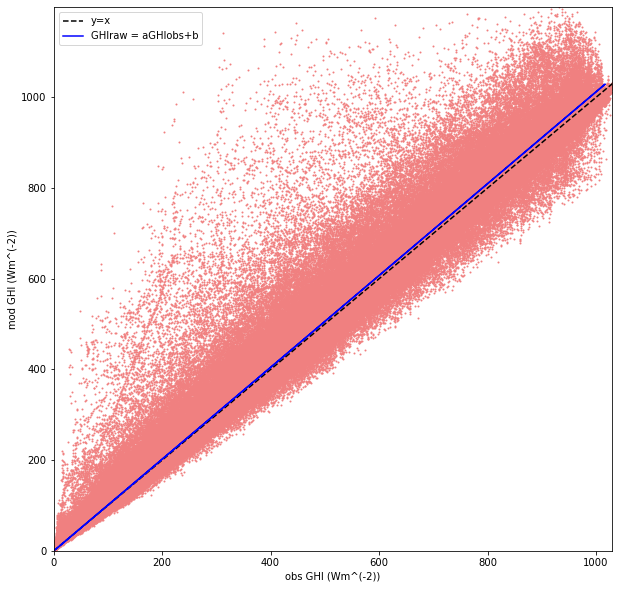

In [34]:
#clear weather conditions (pyranometer)
scatter(clear1['GHIobs'],clear1['GHIraw'],"lightcoral",'clear')

MBE("CLR",clear1['GHIraw'],clear1['GHIobs'],'clear')
RMSE("CLR",clear1['GHIraw'],clear1['GHIobs'],'clear')
R(clear1['GHIraw'],clear1['GHIobs'],'clear')

for intermediate weather conditions
*slope (a) is: [[1.26364804]]
*intercept(b) is [5.2023794]
the MBE index for the intermediate conditions is: -7.374325367348922
the RMSE index for the intermediate conditions is: 45.78295619006285
the R index for the intermediate conditions is: 0.9032759140625379


0.9032759140625379

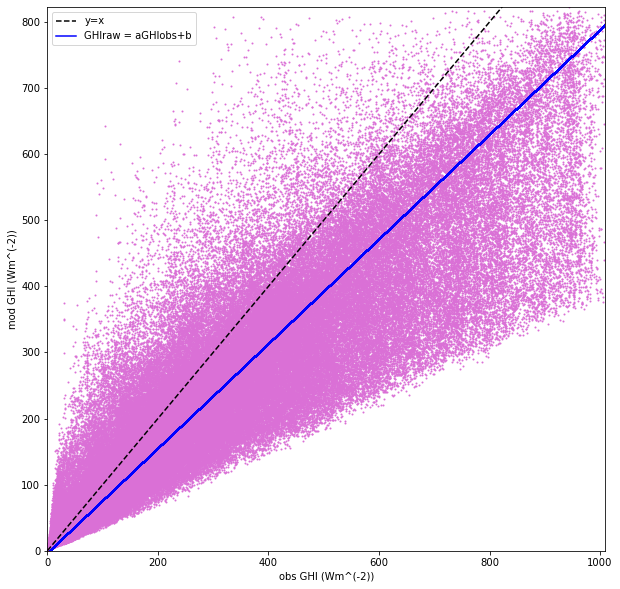

In [35]:
#intermediate weather conditions (pyranometer)

scatter(intermediate1['GHIobs'],intermediate1['GHIraw'],"orchid",'intermediate')

MBE("INT",intermediate1['GHIraw'],intermediate1['GHIobs'],'intermediate')
RMSE("INT",intermediate1['GHIraw'],intermediate1['GHIobs'],'intermediate')
R(intermediate1['GHIraw'],intermediate1['GHIobs'],'intermediate')

for cloudy weather conditions
*slope (a) is: [[1.73314001]]
*intercept(b) is [22.45335421]
the MBE index for the cloudy conditions is: -6.100352007214745
the RMSE index for the cloudy conditions is: 43.21059339902901
the R index for the cloudy conditions is: 0.74371029484084


0.74371029484084

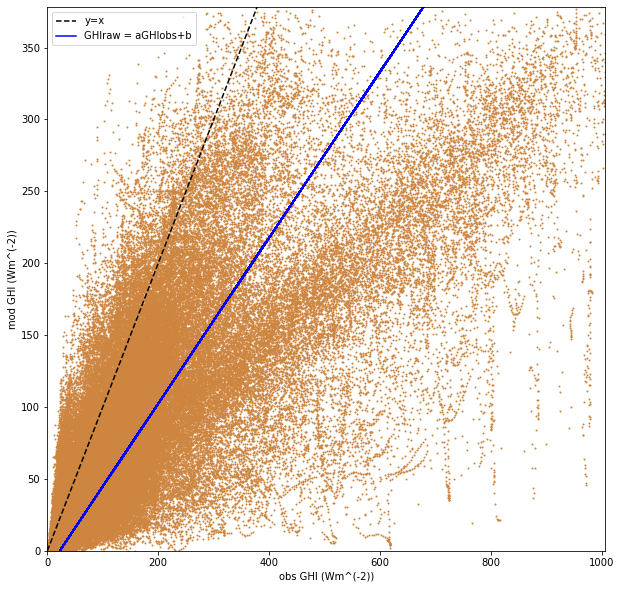

In [36]:
#cloudy weather conditions (pyranometer)

scatter(cloudy1['GHIobs'],cloudy1['GHIraw'],'peru','cloudy')

MBE('cld',cloudy1['GHIraw'],cloudy1['GHIobs'],'cloudy')
RMSE('cld2',cloudy1['GHIraw'],cloudy1['GHIobs'],'cloudy')
R(cloudy1['GHIraw'],cloudy1['GHIobs'],'cloudy')

# LINEAR

for clear weather conditions
*slope (a) is: [[1.01785969]]
*intercept(b) is [-2.33587125]


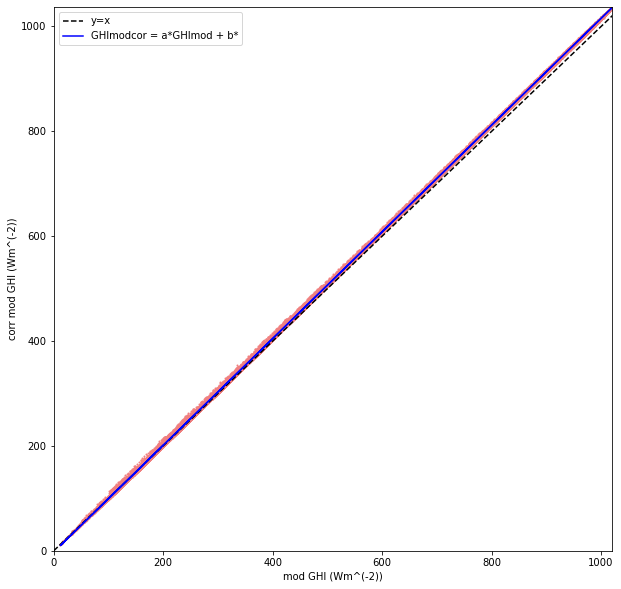

In [94]:
#clear training period 
ast1,bst1 = trainmod(GHIcclr, clear['GHIraw'], 'lightcoral','clear')

for clear weather conditions
*slope (a) is: [[1.00531444]]
*intercept(b) is [-1.9760331]
the MBE index for the clear conditions is: -0.5897428638603296
the RMSE index for the clear conditions is: 29.915213528151895
the R index for the clear conditions is: 0.9850517023125721


0.9850517023125721

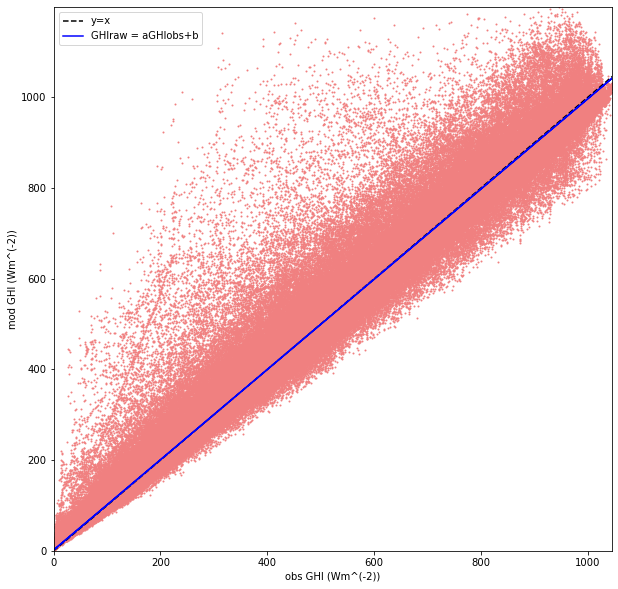

In [38]:
#clear testing period
GHItecorclr = ast1[0][0]*clear1['GHIraw'] + bst1
scatter(clear1['GHIobs'],GHItecorclr,'lightcoral','clear')

MBE("CLR",GHItecorclr,clear1['GHIobs'],'clear')
RMSE("CLR",GHItecorclr,clear1['GHIobs'],'clear')
R(GHItecorclr,clear1['GHIobs'],'clear')

for intermediate weather conditions
*slope (a) is: [[0.9136586]]
*intercept(b) is [-40.00023115]


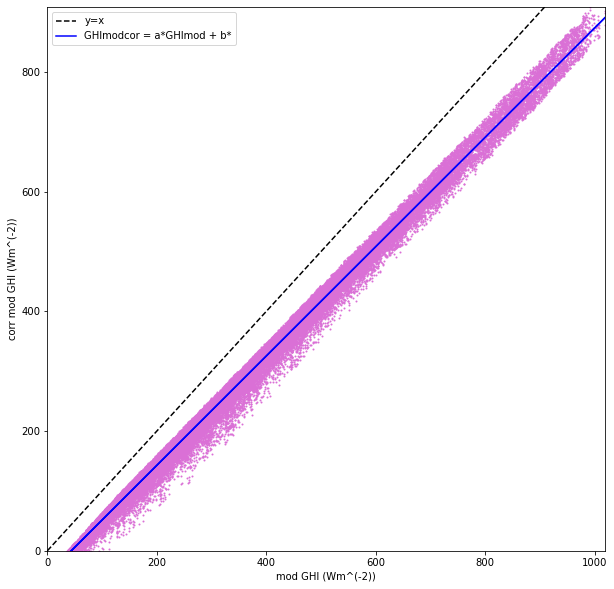

In [95]:
#intermediate training period 
ast2,bst2 = trainmod(GHIcint, intermediate['GHIraw'], 'orchid','intermediate')

for intermediate weather conditions
*slope (a) is: [[1.15454291]]
*intercept(b) is [-35.24703246]
the MBE index for the intermediate conditions is: -0.9489043213472045
the RMSE index for the intermediate conditions is: 34.03216553812439
the R index for the intermediate conditions is: 0.9032759140625383


0.9032759140625383

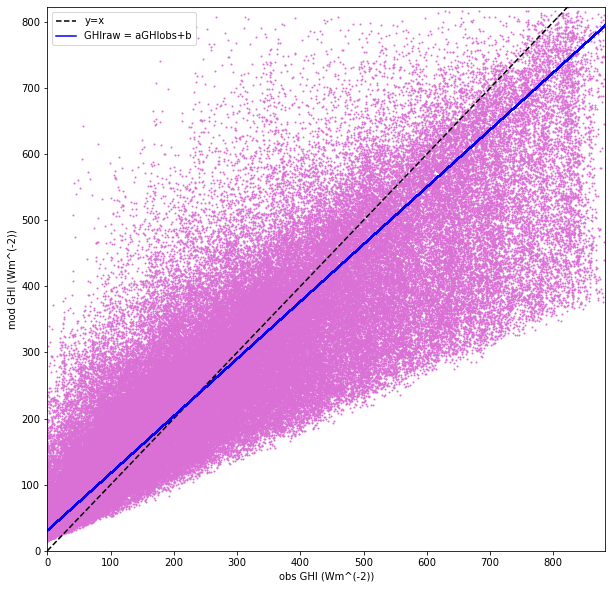

In [40]:
#intermediate testing period
GHItecorint = ast2[0][0]*intermediate1['GHIraw'] + bst2
scatter(intermediate1['GHIobs'],GHItecorint,'orchid','intermediate')

MBE("INT",GHItecorint,intermediate1['GHIobs'],'intermediate')
RMSE("INT",GHItecorint,intermediate1['GHIobs'],'intermediate')
R(GHItecorint,intermediate1['GHIobs'],'intermediate')

for cloudy weather conditions
*slope (a) is: [[0.83015348]]
*intercept(b) is [-63.11237569]


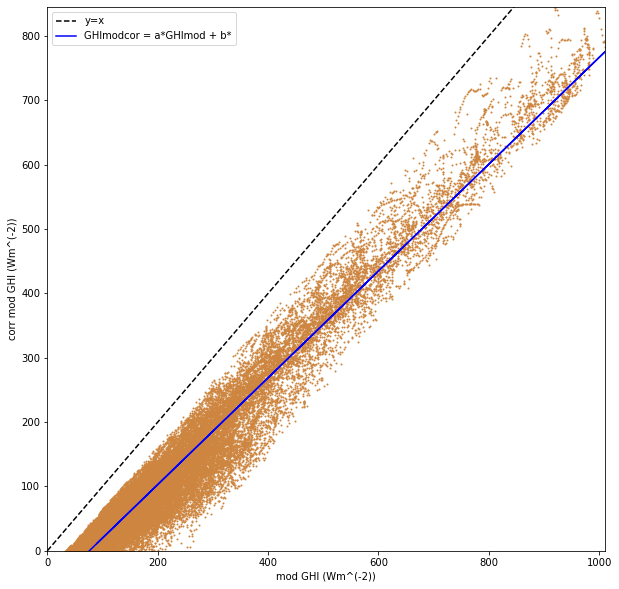

In [96]:
#cloudy training period 
ast3,bst3 = trainmod(GHIccld, cloudy['GHIraw'], 'peru','cloudy')

for cloudy weather conditions
*slope (a) is: [[1.43877221]]
*intercept(b) is [-44.47264564]
the MBE index for the cloudy conditions is: -0.2492283921638519
the RMSE index for the cloudy conditions is: 28.048244538062875
the R index for the cloudy conditions is: 0.7437102948408402


0.7437102948408402

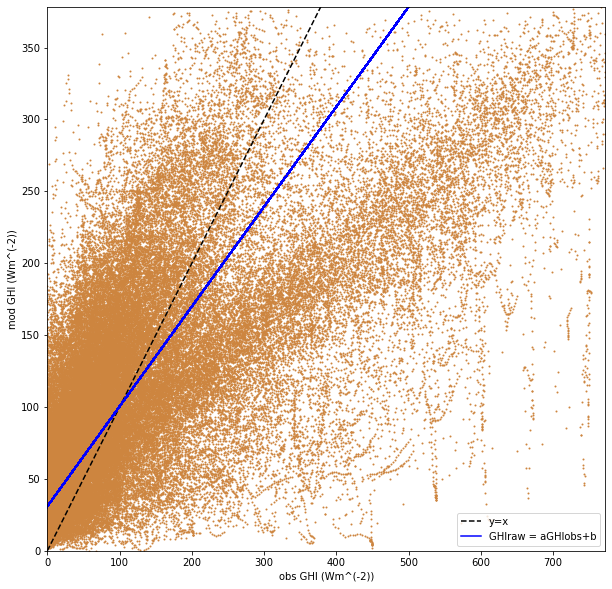

In [42]:
#cloudy testing period
GHItecorcld = ast3[0][0]*cloudy1['GHIraw']+bst3
scatter(cloudy1['GHIobs'],GHItecorcld, 'peru','cloudy')

MBE('cld',GHItecorcld,cloudy1['GHIobs'],'cloudy')
RMSE('cld2',GHItecorcld,cloudy1['GHIobs'],'cloudy')
R(GHItecorcld,cloudy1['GHIobs'],'cloudy')

# EQM

In [43]:
#calculating the percentiles for the module and the observed values for all weather conditions

clobper1 = np.percentile(clear1['GHIobs'],num)
clrawper1 = np.percentile(clear1['GHIraw'],num)

inobper1 = np.percentile(intermediate1['GHIobs'],num)
inrawper1 = np.percentile(intermediate1['GHIraw'],num)

cdobper1 = np.percentile(cloudy1['GHIobs'],num)
cdrawper1 = np.percentile(cloudy1['GHIraw'],num)

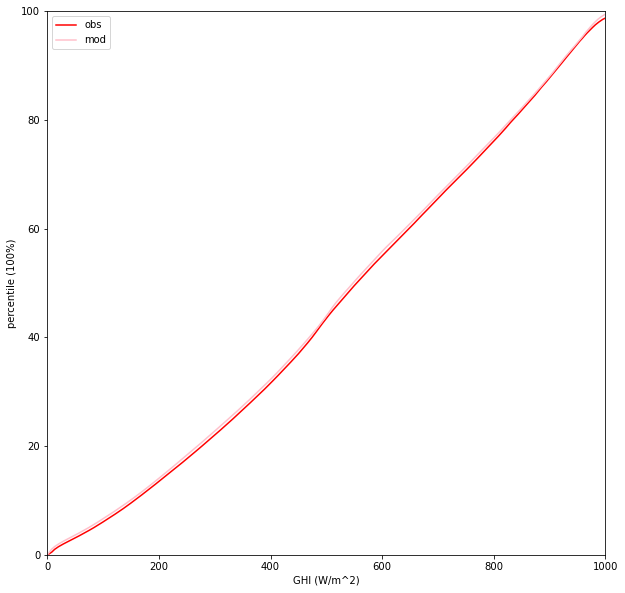

In [44]:
#clear conditions
percent(clobper1,clrawper1)

the MBE index for the clear conditions is: -0.1344844136951569
the RMSE index for the clear conditions is: 29.4928773872337
the R index for the clear conditions is: 0.9849540259416725


0.9849540259416725

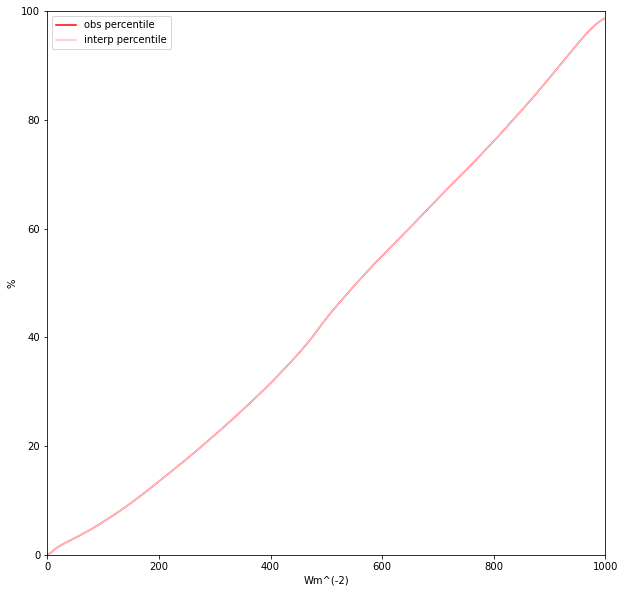

In [45]:
nef11 = interp(clrawper1,clobper1,clear1["GHIraw"])

MBE("clr22", nef11, clear1["GHIobs"], 'clear')
RMSE("clr22", nef11, clear1["GHIobs"], 'clear')
R(nef11, clear1["GHIobs"], 'clear')

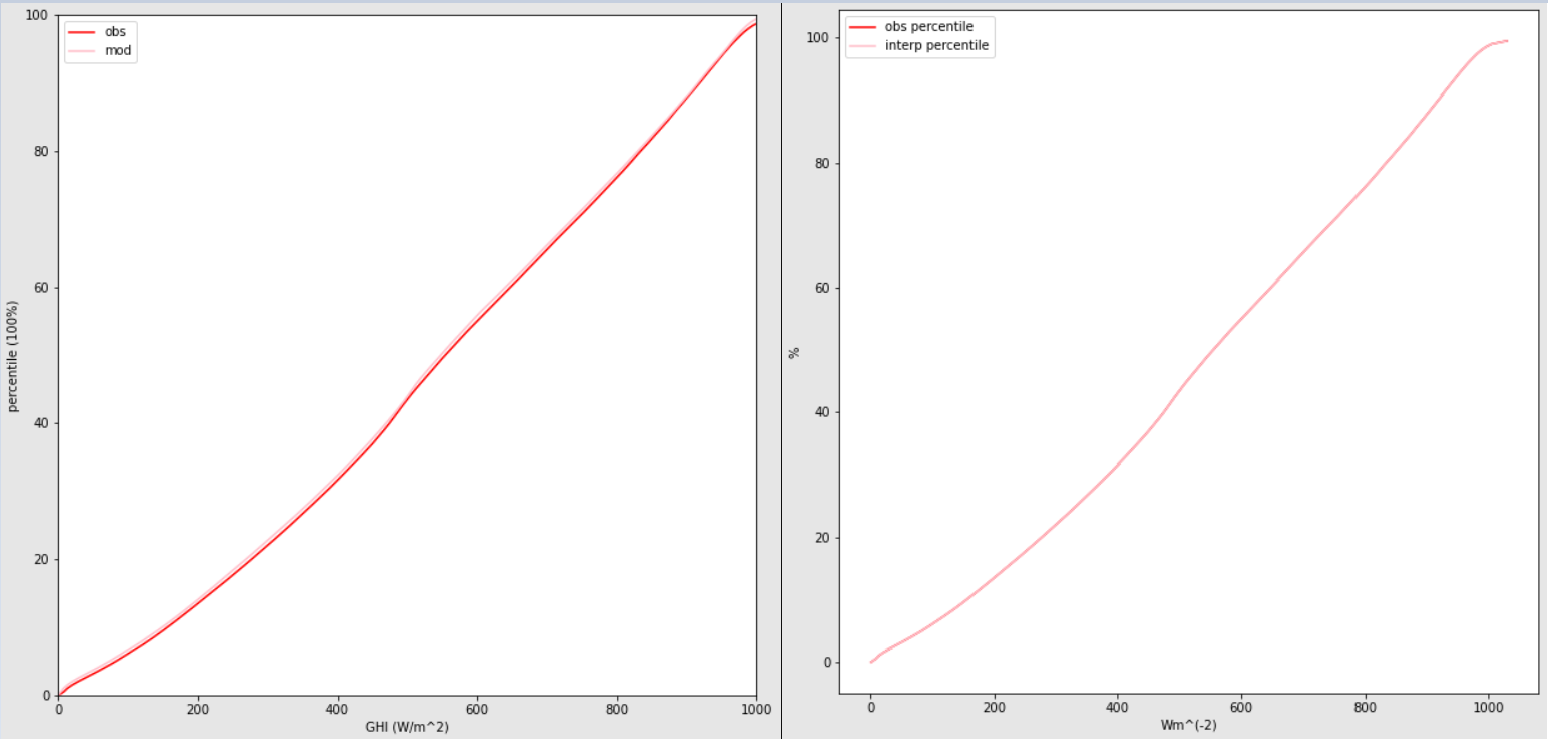

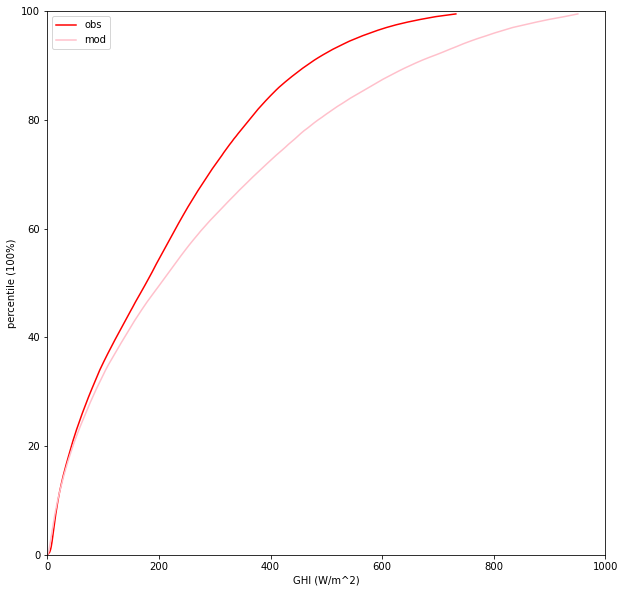

In [46]:
#intermediate conditions
percent(inobper1,inrawper1)

the MBE index for the intermediate conditions is: -0.5522998371608352
the RMSE index for the intermediate conditions is: 25.215443466485823
the R index for the intermediate conditions is: 0.9058425480790974


0.9058425480790974

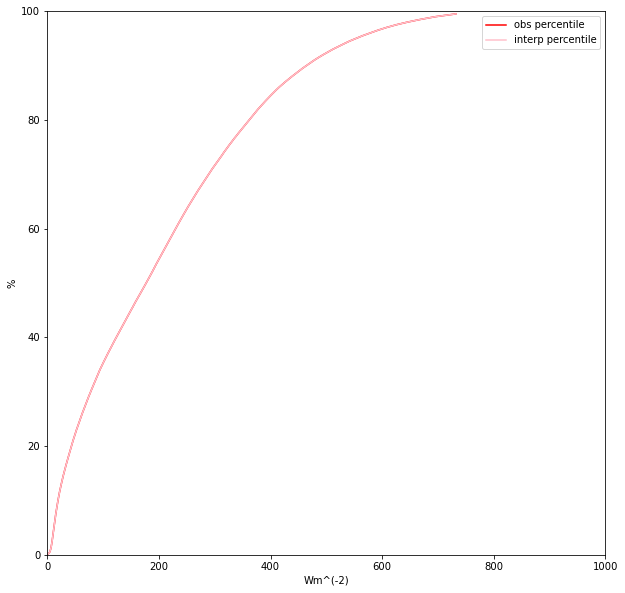

In [47]:
nef22 = interp(inrawper1,inobper1,intermediate1["GHIraw"])

MBE("int22", nef22, intermediate1["GHIobs"], 'intermediate')
RMSE("int22", nef22, intermediate1["GHIobs"], 'intermediate')
R(nef22, intermediate1["GHIobs"], 'intermediate')

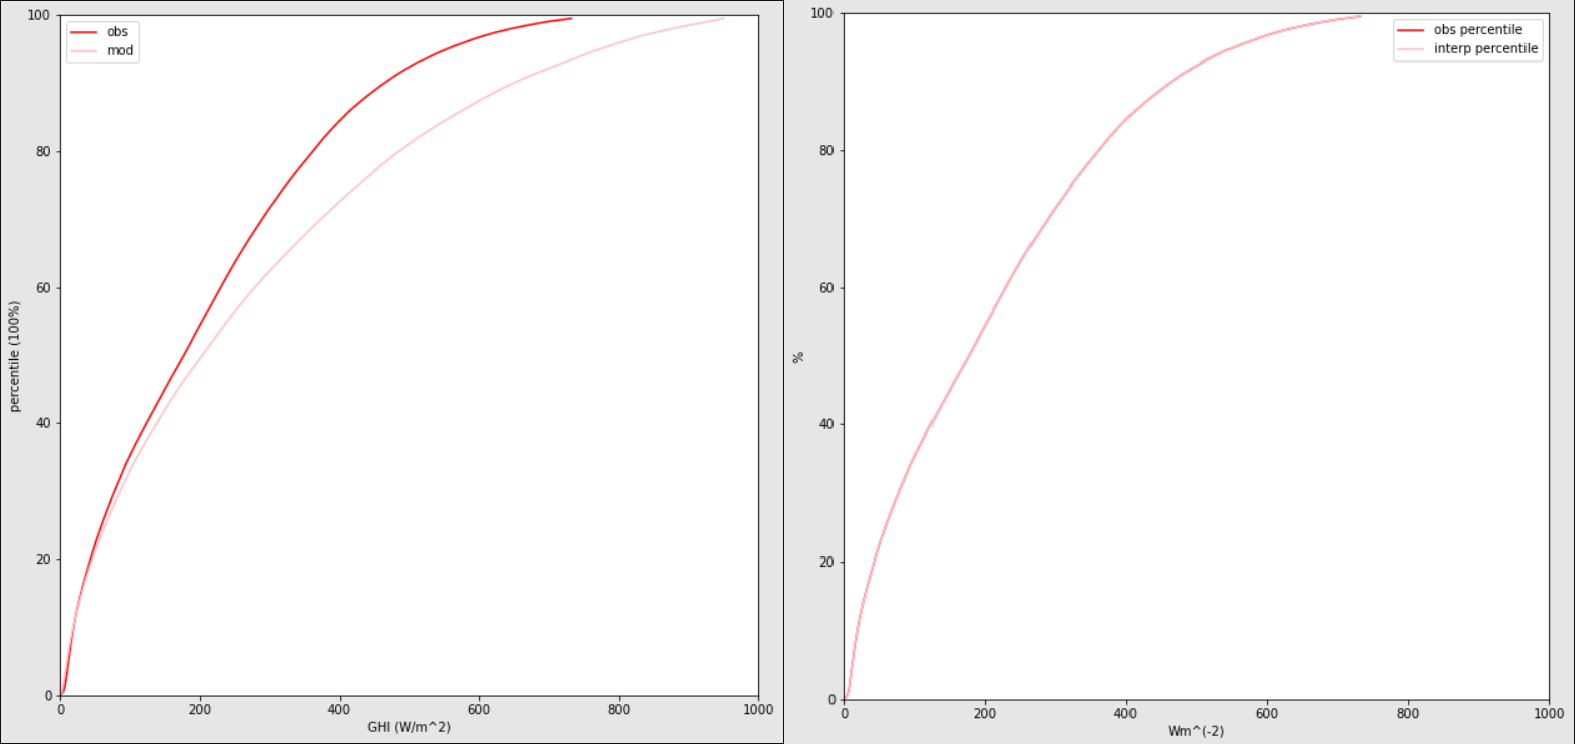

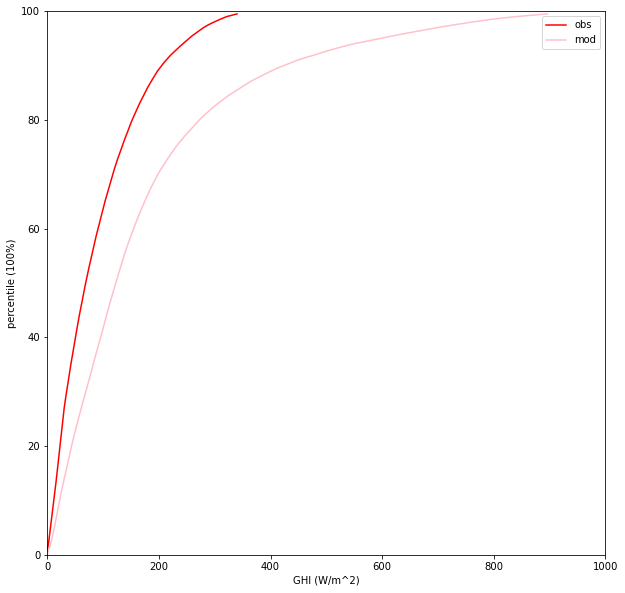

In [48]:
#cloudy conditions 
percent(cdobper1, cdrawper1)

the MBE index for the cloudy conditions is: -0.11596909173838703
the RMSE index for the cloudy conditions is: 13.532034736861908
the R index for the cloudy conditions is: 0.7757100959417713


0.7757100959417713

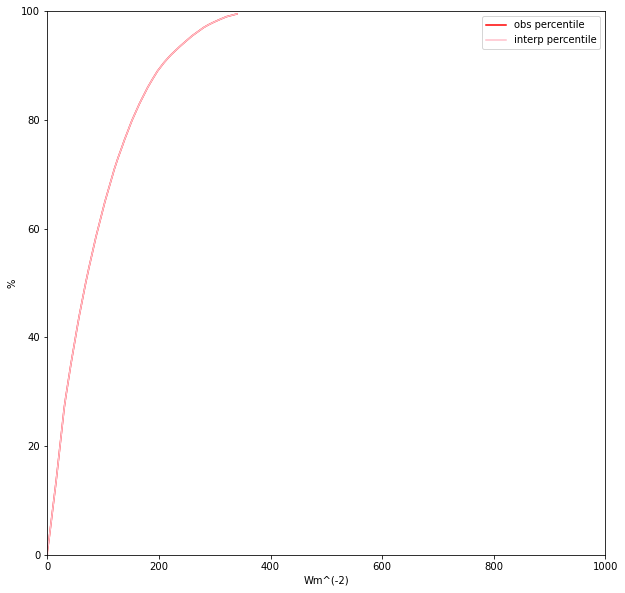

In [49]:
nef33 = interp(cdrawper1,cdobper1,cloudy1["GHIraw"])

MBE("cld22", nef33, cloudy1["GHIobs"], 'cloudy')
RMSE("cld22", nef33, cloudy1["GHIobs"], 'cloudy')
R(nef33, cloudy1["GHIobs"], 'cloudy')

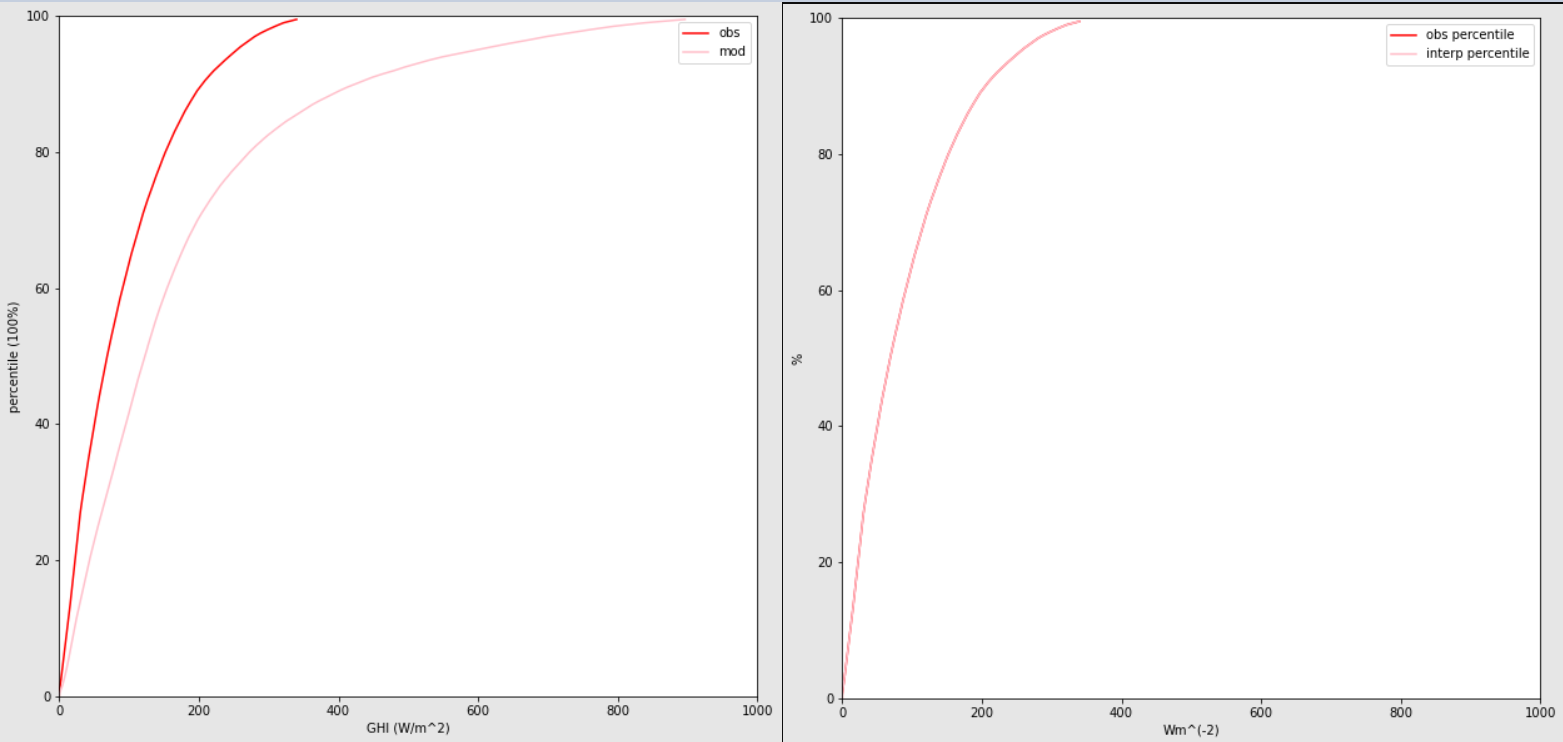

# ENERGY

In [50]:
# energy eqm values (J/m2)
dt['enobs'] = dt['GHIobs']*60

clear1['eneqm']=nef11*60
intermediate1['eneqm']=nef22*60
cloudy1['eneqm']=nef33*60

clear1['enlin']=GHItecorclr*60
intermediate1['enlin'] = GHItecorint*60
cloudy1['enlin'] = GHItecorcld*60

<ipython-input-50-dd58329a1704>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clear1['eneqm']=nef11*60
<ipython-input-50-dd58329a1704>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intermediate1['eneqm']=nef22*60
<ipython-input-50-dd58329a1704>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [51]:
d = {"enobs":dt.groupby(["month","year"])["enobs"].sum(), "clear1eqm":clear1.groupby(["month","year"])["eneqm"].sum(),
    "inter1eqm":intermediate1.groupby(["month","year"])["eneqm"].sum(),
    "cloudy1eqm":cloudy1.groupby(["month","year"])["eneqm"].sum(),
    "clear1enlin":clear1.groupby(["month","year"])['enlin'].sum(),
    "inter1enlin":intermediate1.groupby(["month","year"])['enlin'].sum(),
    "cloudy1enlin":cloudy1.groupby(["month","year"])['enlin'].sum()}

energy = pd.DataFrame(data=d)
energy['eneqm'] = energy['clear1eqm'] + energy['inter1eqm'] + energy['cloudy1eqm']
energy['enlin'] = energy['clear1enlin'] + energy['inter1enlin'] + energy['cloudy1enlin']

energy = energy.reset_index()

print(energy.head(20))

    month  year         enobs     clear1eqm     inter1eqm    cloudy1eqm  \
0       1  2015  2.315707e+08  1.710846e+08  4.230891e+07  2.203545e+07   
1       1  2016  2.328422e+08  1.762503e+08  3.925371e+07  2.007260e+07   
2       1  2017  2.143205e+08  1.476063e+08  4.500997e+07  2.225306e+07   
3       1  2018  2.376787e+08  1.736204e+08  4.867880e+07  1.650193e+07   
4       2  2015  2.942600e+08  2.381105e+08  3.211594e+07  2.486967e+07   
5       2  2016  2.924625e+08  2.097736e+08  5.485148e+07  2.149198e+07   
6       2  2017  3.280894e+08  2.490397e+08  5.385387e+07  1.353989e+07   
7       2  2018  2.271537e+08  1.228548e+08  6.307005e+07  3.309024e+07   
8       3  2015  4.121723e+08  2.870540e+08  8.454890e+07  2.968262e+07   
9       3  2016  4.231345e+08  3.026910e+08  7.626874e+07  4.185125e+07   
10      3  2017  5.305213e+08  4.260749e+08  7.881559e+07  1.848067e+07   
11      3  2018  4.434531e+08  2.950367e+08  1.014901e+08  3.126118e+07   
12      4  2015  6.412034

In [52]:
#adding values in kWh/m2
energy['enobskWh']= energy['enobs']/(3.6*1000000)
energy['eneqmkWh']= energy['eneqm']/(3.6*1000000)
energy['enlinkWh']= energy['enlin']/(3.6*1000000)

In [53]:
#divide sums for each year
y2015 = energy[energy['year'].eq(2015)]
y2016 = energy[energy['year'].eq(2016)]
y2017 = energy[energy['year'].eq(2017)]
y2018 = energy[energy['year'].eq(2018)]

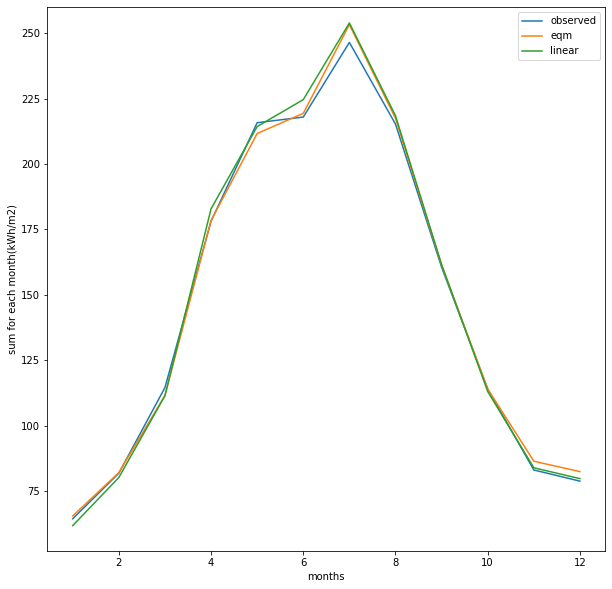

In [54]:
#energy diagram for the year 2015
ener(y2015['month'],y2015['enobskWh'],y2015['eneqmkWh'],y2015['enlinkWh'])

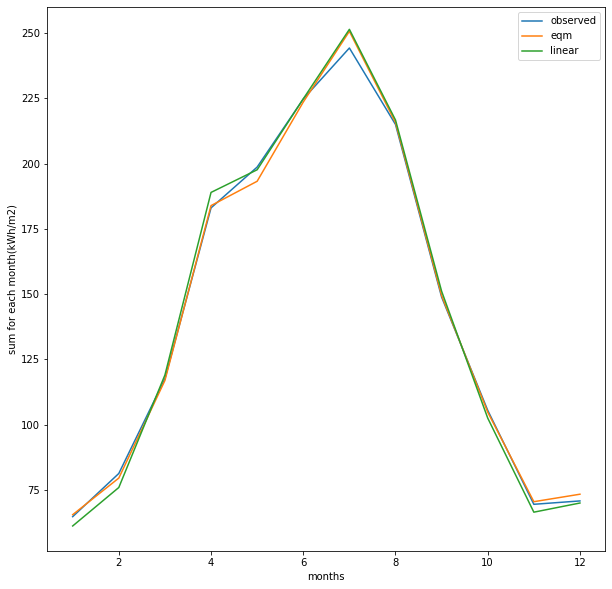

In [55]:
#energy diagram for the year 2016
ener(y2016['month'],y2016['enobskWh'],y2016['eneqmkWh'],y2016['enlinkWh'])

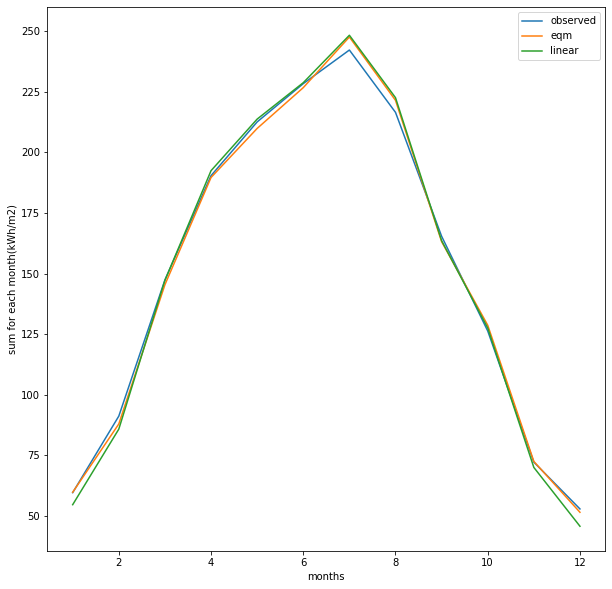

In [56]:
#energy diagram for the year 2017
ener(y2017['month'],y2017['enobskWh'],y2017['eneqmkWh'],y2017['enlinkWh'])

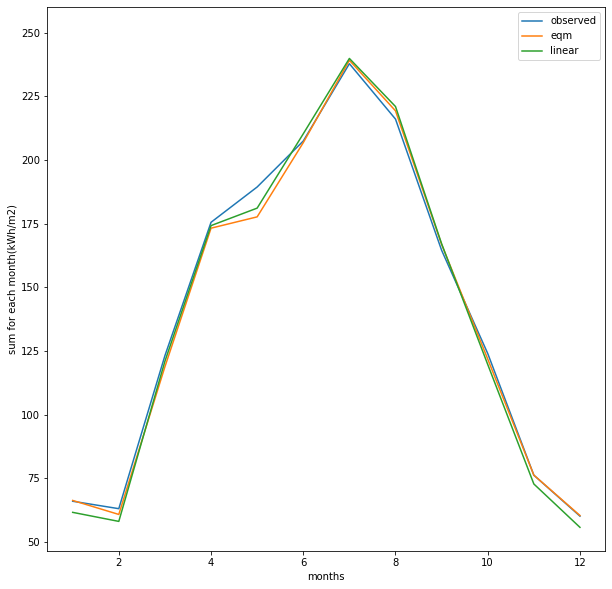

In [57]:
#energy diagram for the year 2018
ener(y2018['month'],y2018['enobskWh'],y2018['eneqmkWh'],y2018['enlinkWh'])

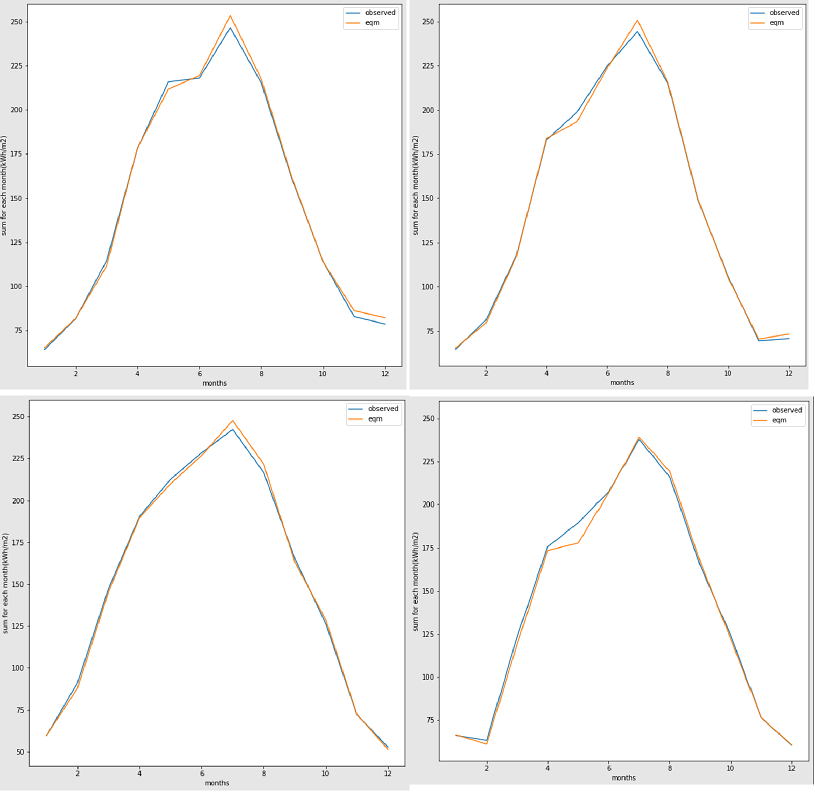

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


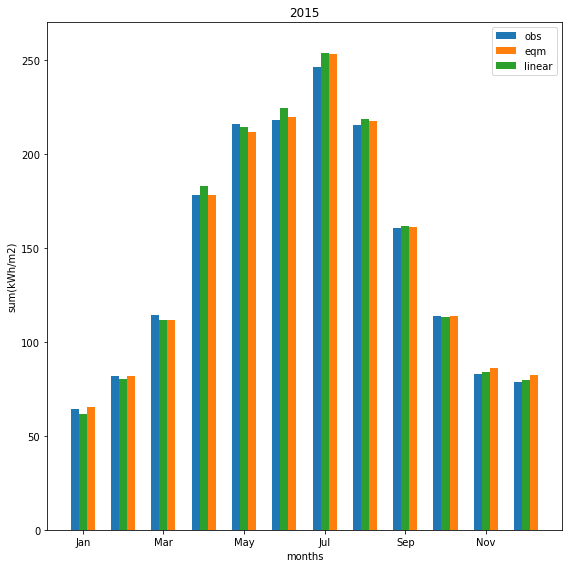

the sum of observed data for 2015 is 1770.52 kWh
the sum of corrected linear data for 2015 is 1785.53 kWh
the sum of corrected eqm data for 2015 is 1783.12 kWh


In [58]:
# energy bar plot 2015
bar(y2015['enobskWh'],y2015['eneqmkWh'],y2015['enlinkWh'],'sum(kWh/m2)',270, '2015')
print('the sum of observed data for 2015 is' ,"%.2f" %y2015['enobskWh'].sum() ,'kWh')
print('the sum of corrected linear data for 2015 is', "%.2f" %sum(y2015['enlinkWh']) ,'kWh')
print('the sum of corrected eqm data for 2015 is', "%.2f" %sum(y2015['eneqmkWh']) ,'kWh')

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


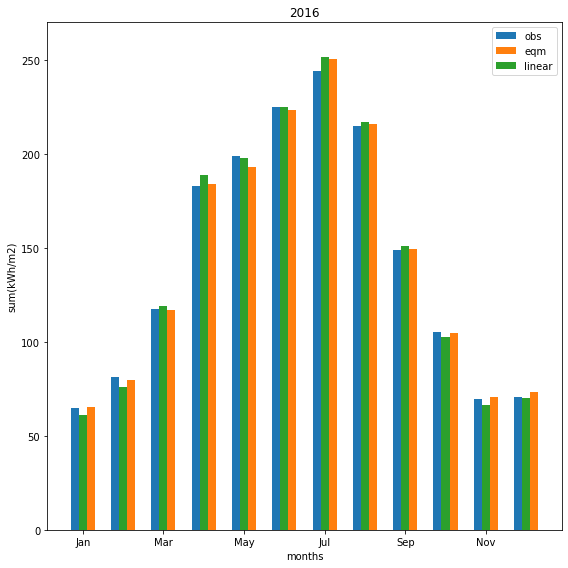

the sum of observed data for 2016 is 1723.89 kWh
the sum of corrected linear data for 2016 is 1725.65 kWh
the sum of corrected eqm data for 2016 is 1727.12 kWh


In [59]:
# energy bar plot 2016
bar(y2016['enobskWh'],y2016['eneqmkWh'],y2016['enlinkWh'],'sum(kWh/m2)',270, '2016')
print('the sum of observed data for 2016 is' ,"%.2f" %sum(y2016['enobskWh']) ,'kWh')
print('the sum of corrected linear data for 2016 is', "%.2f" %sum(y2016['enlinkWh']) ,'kWh')
print('the sum of corrected eqm data for 2016 is', "%.2f" %sum(y2016['eneqmkWh']) ,'kWh')

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


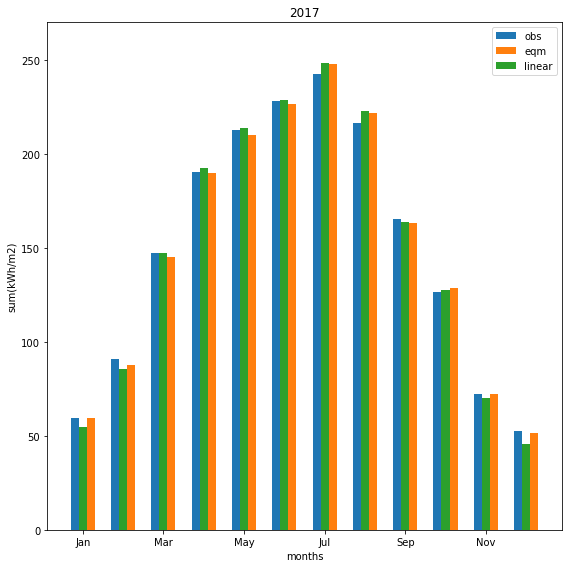

the sum of observed data for 2017 is 1805.05 kWh
the sum of corrected linear data for 2017 is 1800.40 kWh
the sum of corrected eqm data for 2017 is 1804.27 kWh


In [60]:
# energy bar plot 2017
bar(y2017['enobskWh'],y2017['eneqmkWh'],y2017['enlinkWh'],'sum(kWh/m2)',270,'2017')
print('the sum of observed data for 2017 is' ,"%.2f" %sum(y2017['enobskWh']) ,'kWh')
print('the sum of corrected linear data for 2017 is', "%.2f" %sum(y2017['enlinkWh']) ,'kWh')
print('the sum of corrected eqm data for 2017 is', "%.2f" %sum(y2017['eneqmkWh']) ,'kWh')

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


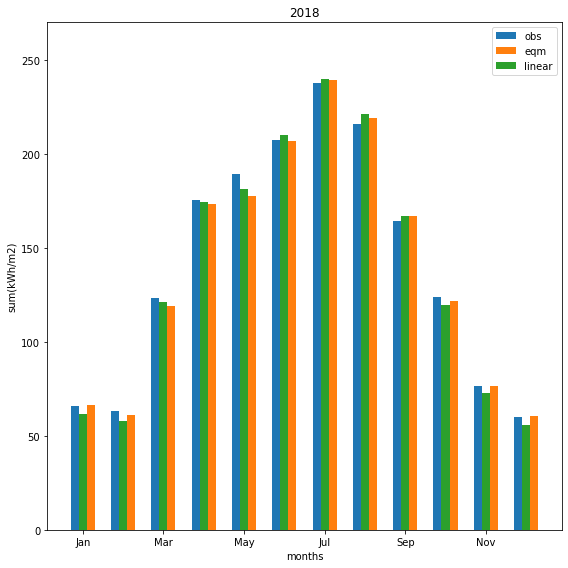

the sum of observed data for 2018 is 1703.62 kWh
the sum of corrected linear data for 2018 is 1682.70 kWh
the sum of corrected eqm data for 2018 is 1687.62 kWh


In [61]:
# energy bar plot 2018
bar(y2018['enobskWh'],y2018['eneqmkWh'],y2018['enlinkWh'],'sum(kWh/m2)',270,'2018')
print('the sum of observed data for 2018 is' ,"%.2f" %sum(y2018['enobskWh']) ,'kWh')
print('the sum of corrected linear data for 2018 is', "%.2f" %sum(y2018['enlinkWh']) ,'kWh')
print('the sum of corrected eqm data for 2018 is', "%.2f" %sum(y2018['eneqmkWh']) ,'kWh')

# MEAN RADIATION

In [62]:
clear1['radeqm'] = nef11
intermediate1['radeqm'] = nef22
cloudy1['radeqm'] = nef33

clear1['radlin'] = GHItecorclr
intermediate1['radlin'] = GHItecorint
cloudy1['radlin'] = GHItecorcld

<ipython-input-62-37a62ac9cf37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clear1['radeqm'] = nef11
<ipython-input-62-37a62ac9cf37>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intermediate1['radeqm'] = nef22
<ipython-input-62-37a62ac9cf37>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [63]:
r = {"obs":dt.groupby(["month","year"])["GHIobs"].mean(), "clear1obs":clear1.groupby(["month","year"])["GHIobs"].mean(),
     "inter1obs":intermediate1.groupby(["month","year"])["GHIobs"].mean(),
     "cloudy1obs":cloudy1.groupby(["month","year"])["GHIobs"].mean(),
     "clear1eqm":clear1.groupby(["month","year"])["radeqm"].mean(),
    "inter1eqm":intermediate1.groupby(["month","year"])["radeqm"].mean(),
     "cloudy1eqm":cloudy1.groupby(["month","year"])["radeqm"].mean(),
    'clear1lin':clear1.groupby(["month","year"])["radlin"].mean(),
    "inter1lin":intermediate1.groupby(["month","year"])["radlin"].mean(),
    "cloudy1lin":cloudy1.groupby(["month","year"])["radlin"].mean()}

radiation = pd.DataFrame(data=r)
#radiation['radeqm'] = (radiation['clear1eqm'] + radiation['inter1eqm'] + radiation['cloudy1eqm'])/3
#radiation['radlin'] = (radiation['clear1lin'] + radiation['inter1lin'] + radiation['cloudy1lin'])/3


radiation = radiation.reset_index()

print(radiation.head(15))

    month  year         obs   clear1obs   inter1obs  cloudy1obs   clear1eqm  \
0       1  2015   88.555444  368.087430  166.546535   63.407345  366.316889   
1       1  2016   88.864301  377.959678  150.199040   63.020815  378.105854   
2       1  2017   81.506174  387.969344  162.749563   55.807338  386.748131   
3       1  2018   90.068709  374.012254  161.823164   61.331493  376.878487   
4       2  2015  124.132042  443.303338  180.727035   75.765114  441.878312   
5       2  2016  118.160932  448.101884  197.193016   81.535055  450.196652   
6       2  2017  137.716137  450.006692  204.062538   75.854862  433.942638   
7       2  2018   96.039948  442.727163  202.845518   82.011922  425.338597   
8       3  2015  160.589548  564.293074  259.176595   88.305494  550.671424   
9       3  2016  163.053851  542.968404  265.797657  100.246564  532.437991   
10      3  2017  200.941353  535.639373  257.366257  112.435632  525.940517   
11      3  2018  170.958646  558.305889  282.044494 

In [64]:
#divide means for each year
yr2015 = radiation[radiation['year'].eq(2015)]
yr2016 = radiation[radiation['year'].eq(2016)]
yr2017 = radiation[radiation['year'].eq(2017)]
yr2018 = radiation[radiation['year'].eq(2018)]

print(yr2015)

    month  year         obs   clear1obs   inter1obs  cloudy1obs   clear1eqm  \
0       1  2015   88.555444  368.087430  166.546535   63.407345  366.316889   
4       2  2015  124.132042  443.303338  180.727035   75.765114  441.878312   
8       3  2015  160.589548  564.293074  259.176595   88.305494  550.671424   
12      4  2015  254.651934  597.219598  281.319456  135.853301  593.911487   
16      5  2015  300.659128  632.392670  271.252876  158.963217  620.612837   
20      6  2015  316.796500  649.948716  279.528123  153.456751  642.835382   
24      7  2015  335.144910  622.747749  116.097677  139.325155  638.172384   
28      8  2015  295.636683  605.666106  191.551645  123.017907  610.847887   
32      9  2015  228.870017  545.758932  211.432414  115.800150  551.451265   
36     10  2015  156.693409  468.830432  207.549997   99.995588  469.936629   
40     11  2015  117.700745  380.576844  164.017814   58.216433  394.523812   
44     12  2015  107.189767  340.148993  113.069123 

### line plots

## 2015

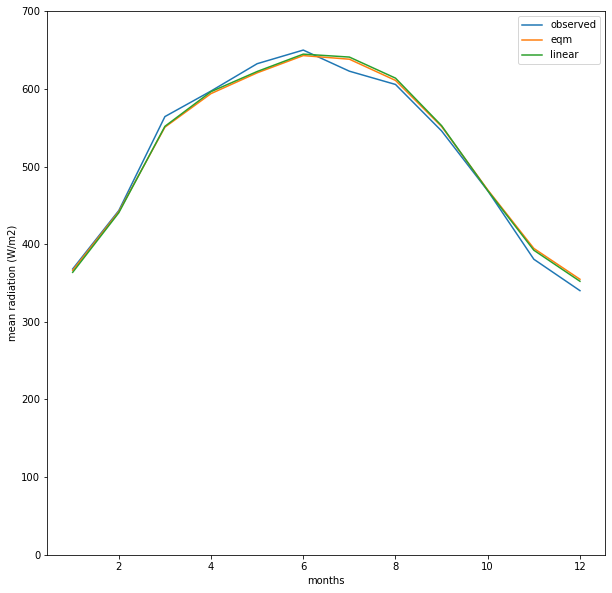

In [65]:
#clear conditions 
meanrad(yr2015['month'],yr2015['clear1obs'],yr2015['clear1eqm'],yr2015['clear1lin'],700)

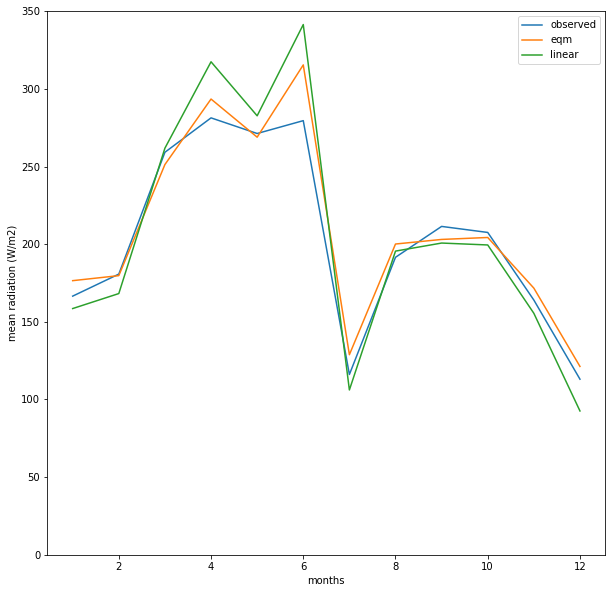

In [66]:
#intermediate conditions 
meanrad(yr2015['month'],yr2015['inter1obs'],yr2015['inter1eqm'],yr2015['inter1lin'],350)

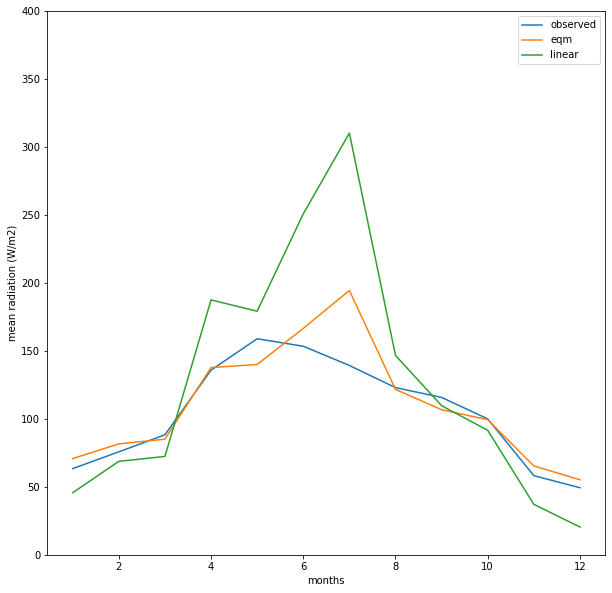

In [67]:
#cloudy conditions 
meanrad(yr2015['month'],yr2015['cloudy1obs'],yr2015['cloudy1eqm'],yr2015['cloudy1lin'],400)

## 2016

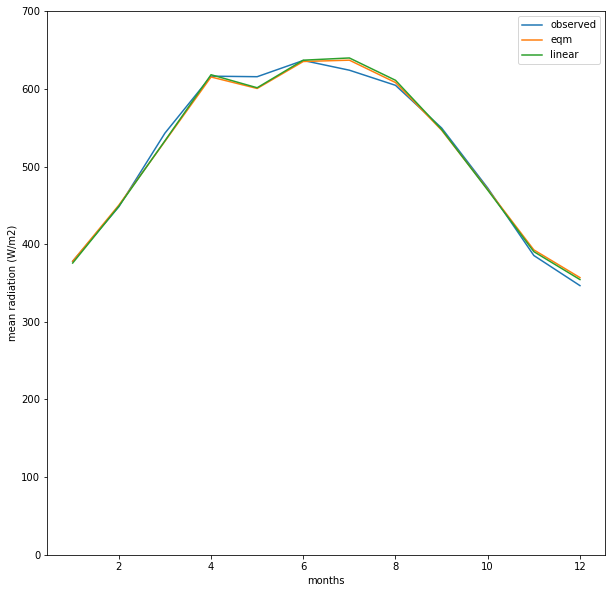

In [68]:
#clear conditions 
meanrad(yr2016['month'],yr2016['clear1obs'],yr2016['clear1eqm'],yr2016['clear1lin'],700)

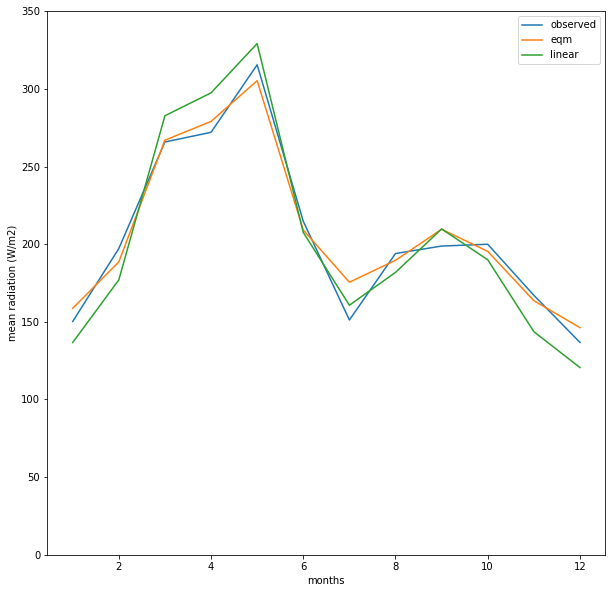

In [69]:
#intermediate conditions 
meanrad(yr2016['month'],yr2016['inter1obs'],yr2016['inter1eqm'],yr2016['inter1lin'],350)

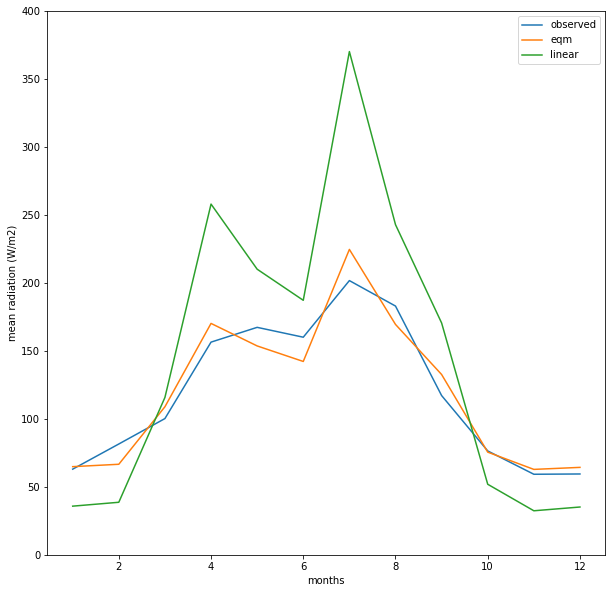

In [70]:
#cloudy conditions 
meanrad(yr2016['month'],yr2016['cloudy1obs'],yr2016['cloudy1eqm'],yr2016['cloudy1lin'],400)

## 2017

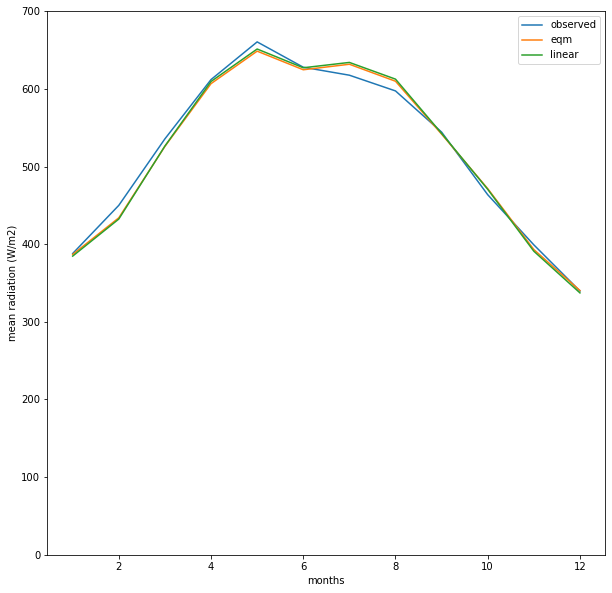

In [71]:
#clear conditions 
meanrad(yr2017['month'],yr2017['clear1obs'],yr2017['clear1eqm'],yr2017['clear1lin'],700)

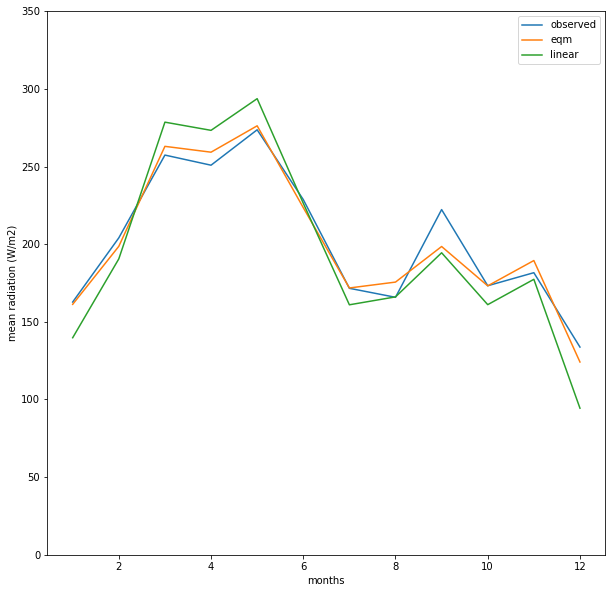

In [72]:
#intermediate conditions 
meanrad(yr2017['month'],yr2017['inter1obs'],yr2017['inter1eqm'],yr2017['inter1lin'],350)

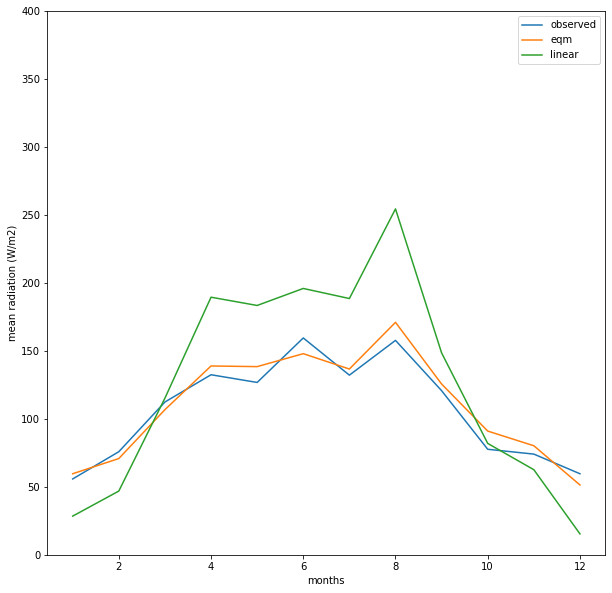

In [73]:
#cloudy conditions 
meanrad(yr2017['month'],yr2017['cloudy1obs'],yr2017['cloudy1eqm'],yr2017['cloudy1lin'],400)

## 2018

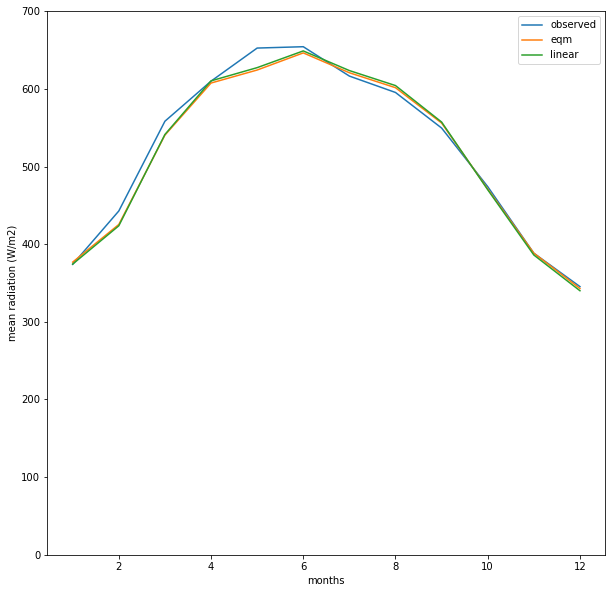

In [74]:
#clear conditions 
meanrad(yr2018['month'],yr2018['clear1obs'],yr2018['clear1eqm'],yr2018['clear1lin'],700)

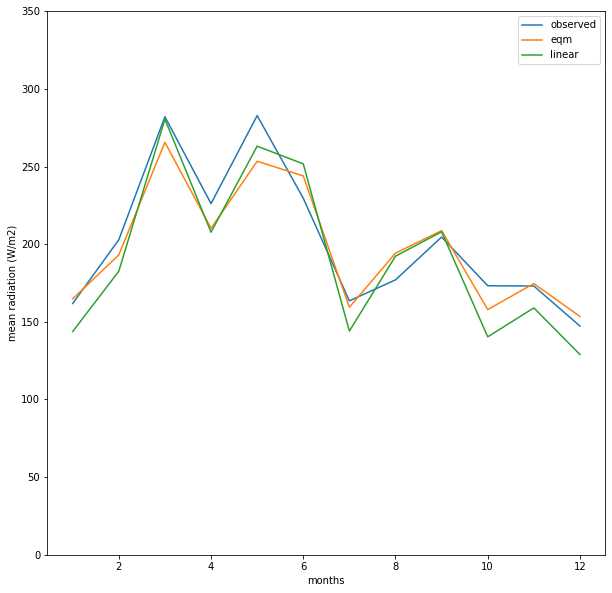

In [75]:
#intermediate conditions 
meanrad(yr2018['month'],yr2018['inter1obs'],yr2018['inter1eqm'],yr2018['inter1lin'],350)

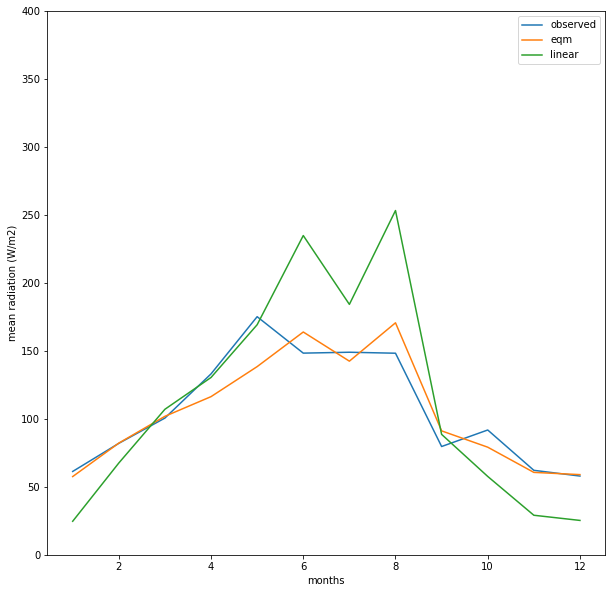

In [76]:
#cloudy conditions 
meanrad(yr2018['month'],yr2018['cloudy1obs'],yr2018['cloudy1eqm'],yr2018['cloudy1lin'],400)

### bar plots

## 2015

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


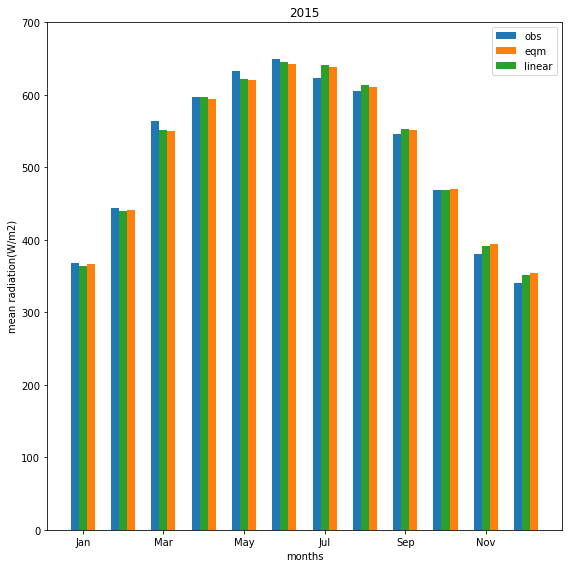

In [77]:
#clear conditions
bar(yr2015['clear1obs'],yr2015['clear1eqm'],yr2015['clear1lin'],'mean radiation(W/m2)',700, '2015')

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


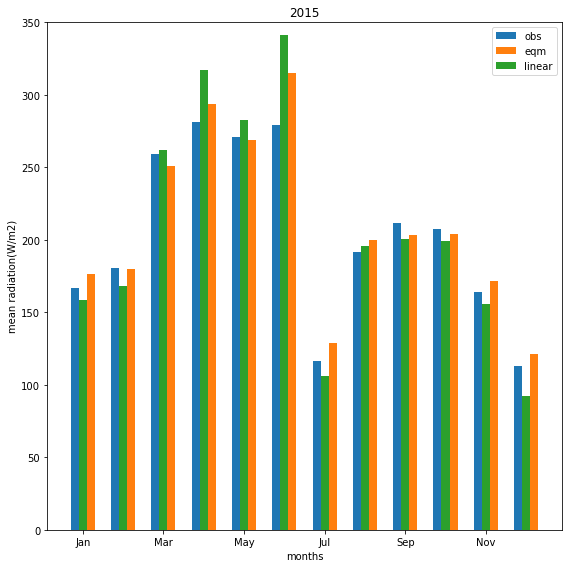

In [78]:
#intermediate conditions
bar(yr2015['inter1obs'],yr2015['inter1eqm'],yr2015['inter1lin'],'mean radiation(W/m2)',350, '2015')

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


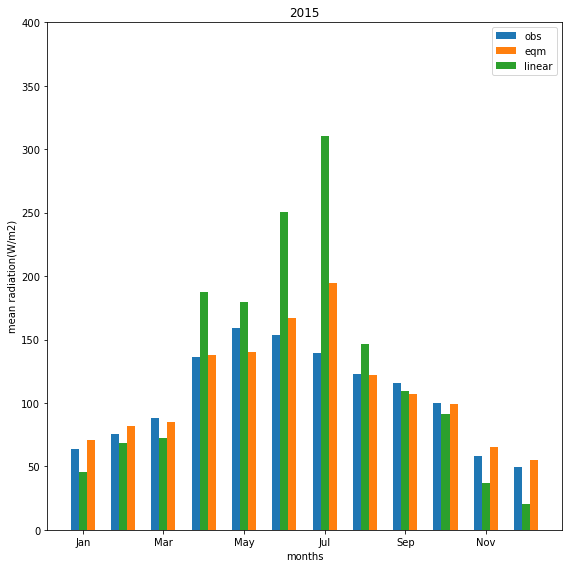

In [79]:
#cloudy conditions
bar(yr2015['cloudy1obs'],yr2015['cloudy1eqm'],yr2015['cloudy1lin'],'mean radiation(W/m2)',400, '2015')

## 2016

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


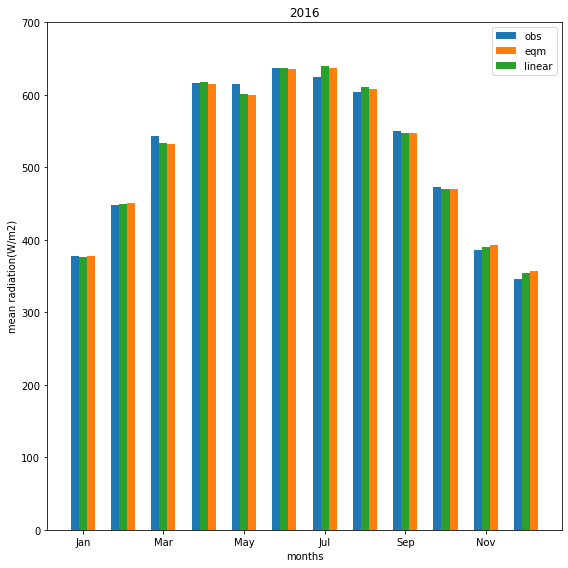

In [80]:
#clear conditions
bar(yr2016['clear1obs'],yr2016['clear1eqm'],yr2016['clear1lin'],'mean radiation(W/m2)',700, '2016')

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


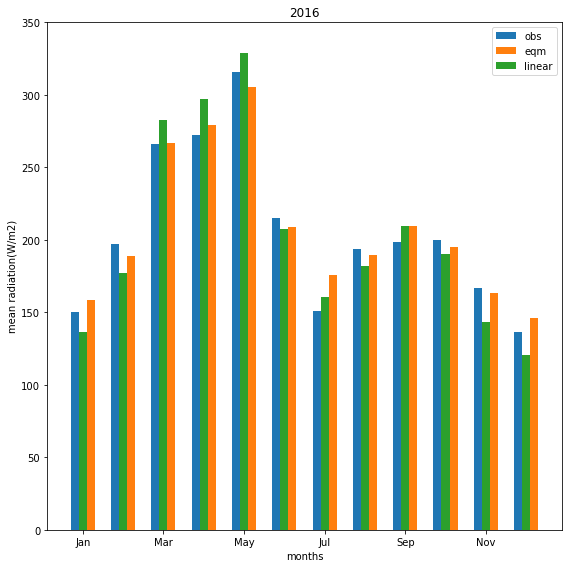

In [81]:
#intermediate conditions
bar(yr2016['inter1obs'],yr2016['inter1eqm'],yr2016['inter1lin'],'mean radiation(W/m2)',350, '2016')

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


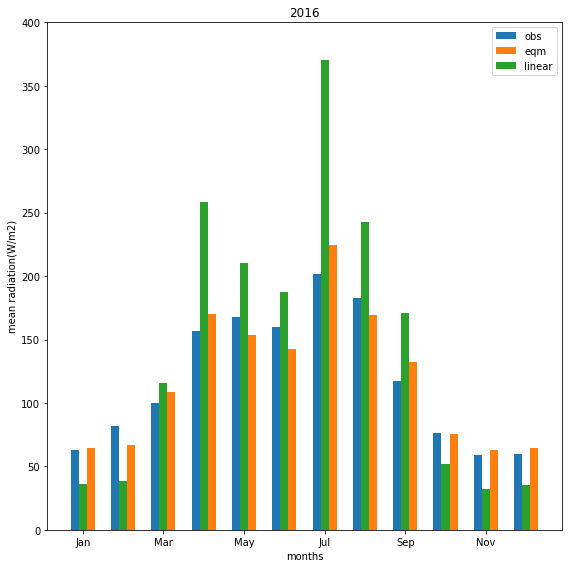

In [82]:
#cloudy conditions
bar(yr2016['cloudy1obs'],yr2016['cloudy1eqm'],yr2016['cloudy1lin'],'mean radiation(W/m2)',400, '2016')

## 2017

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


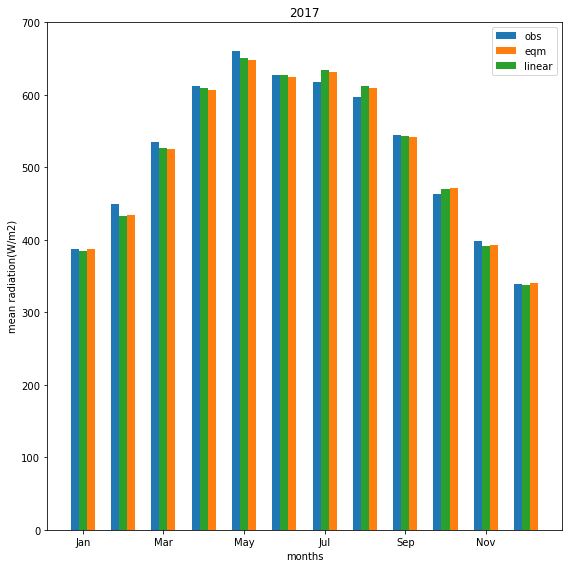

In [83]:
#clear conditions
bar(yr2017['clear1obs'],yr2017['clear1eqm'],yr2017['clear1lin'],'mean radiation(W/m2)',700, '2017')

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


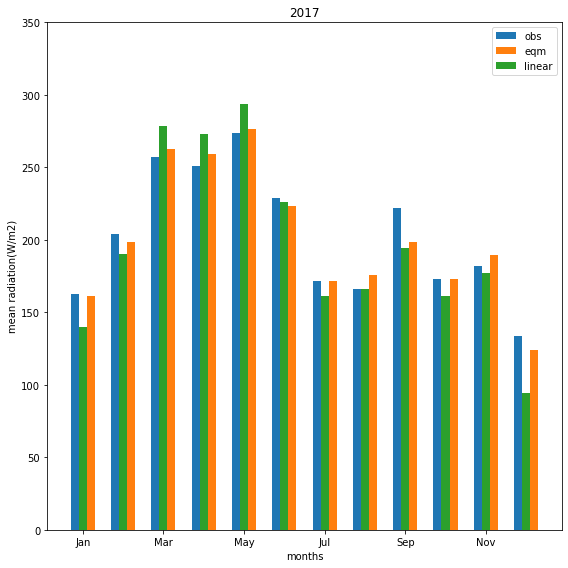

In [84]:
#intermediate conditions
bar(yr2017['inter1obs'],yr2017['inter1eqm'],yr2017['inter1lin'],'mean radiation(W/m2)',350, '2017')

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


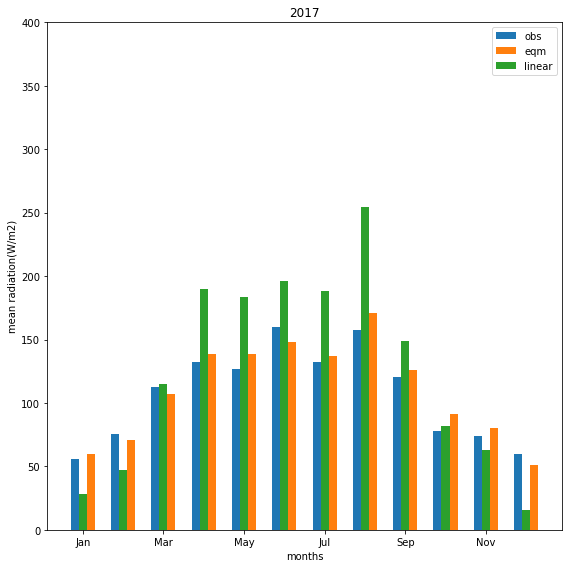

In [85]:
#cloudy conditions
bar(yr2017['cloudy1obs'],yr2017['cloudy1eqm'],yr2017['cloudy1lin'],'mean radiation(W/m2)',400, '2017')

## 2018

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


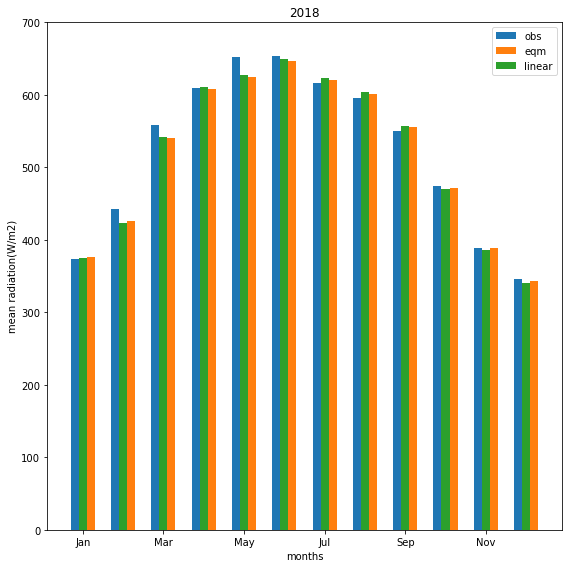

In [86]:
#clear conditions
bar(yr2018['clear1obs'],yr2018['clear1eqm'],yr2018['clear1lin'],'mean radiation(W/m2)',700, '2018')

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


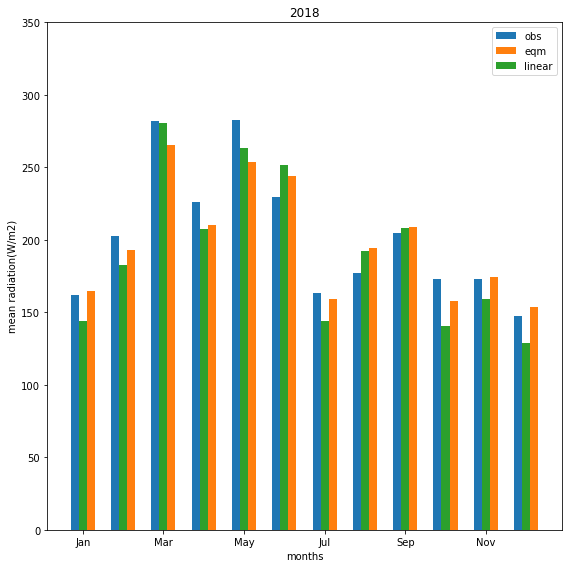

In [87]:
#intermediate conditions
bar(yr2018['inter1obs'],yr2018['inter1eqm'],yr2018['inter1lin'],'mean radiation(W/m2)',350, '2018')

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


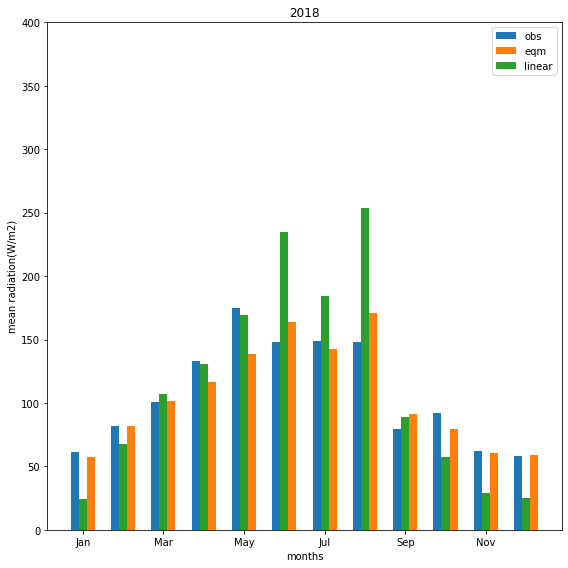

In [88]:
#cloudy conditions
bar(yr2018['cloudy1obs'],yr2018['cloudy1eqm'],yr2018['cloudy1lin'],'mean radiation(W/m2)',400, '2018')

In [89]:
#mean radiation for all the years 

mrad= {
'meanclear1obs':((yr2015['clear1obs'].values + yr2016['clear1obs'].values +  yr2017['clear1obs'].values +  yr2018['clear1obs'].values)/4),
'meaninter1obs': ((yr2015['inter1obs'].values + yr2016['inter1obs'].values +  yr2017['inter1obs'].values +  yr2018['inter1obs'].values)/4),
'meancloudy1obs':((yr2015['cloudy1obs'].values + yr2016['cloudy1obs'].values +  yr2017['cloudy1obs'].values +  yr2018['cloudy1obs'].values)/4),
'meanclear1lin':((yr2015['clear1lin'].values + yr2016['clear1lin'].values +  yr2017['clear1lin'].values +  yr2018['clear1lin'].values)/4),
'meaninter1lin':((yr2015['inter1lin'].values + yr2016['inter1lin'].values +  yr2017['inter1lin'].values +  yr2018['inter1lin'].values)/4),
'meancloudy1lin':((yr2015['cloudy1lin'].values + yr2016['cloudy1lin'].values +  yr2017['cloudy1lin'].values +  yr2018['cloudy1lin'].values)/4),
'meanclear1eqm':((yr2015['clear1eqm'].values + yr2016['clear1eqm'].values +  yr2017['clear1eqm'].values +  yr2018['clear1eqm'].values)/4),
'meaninter1eqm':((yr2015['inter1eqm'].values + yr2016['inter1eqm'].values +  yr2017['inter1eqm'].values +  yr2018['inter1eqm'].values)/4),
'meancloudy1eqm':((yr2015['cloudy1eqm'].values + yr2016['cloudy1eqm'].values +  yr2017['cloudy1eqm'].values +  yr2018['cloudy1eqm'].values)/4)}
meanrad = pd.DataFrame(data=mrad)
print(meanrad)

    meanclear1obs  meaninter1obs  meancloudy1obs  meanclear1lin  \
0      377.007177     160.329575       60.891748     374.590519   
1      446.034769     196.207027       78.791738     436.339849   
2      550.301685     266.096251      100.403192     538.146667   
3      608.858701     257.568621      139.492153     608.604008   
4      640.259792     285.795477      157.091095     625.595682   
5      642.157222     238.148843      155.381268     639.415421   
6      620.200809     150.590150      155.586277     634.573736   
7      600.724612     182.087770      153.039051     610.401354   
8      547.298834     209.269836      108.350912     550.047881   
9      469.712999     188.491231       86.474151     469.845043   
10     388.359754     171.443962       63.436213     389.877245   
11     342.947196     132.703754       56.596957     345.972422   

    meaninter1lin  meancloudy1lin  meanclear1eqm  meaninter1eqm  \
0      144.680627       33.648051     377.012341     165.3107

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


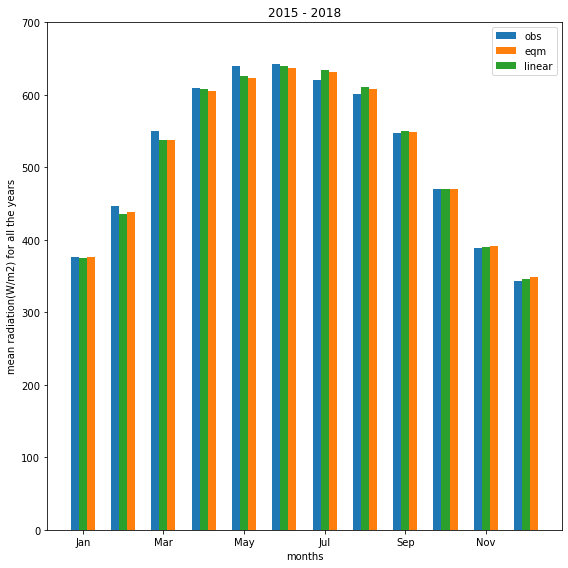

In [90]:
#clear conditions
bar(meanrad['meanclear1obs'],meanrad['meanclear1eqm'],meanrad['meanclear1lin'],'mean radiation(W/m2) for all the years',700, '2015 - 2018')

<ipython-input-8-b9d724e605bb>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


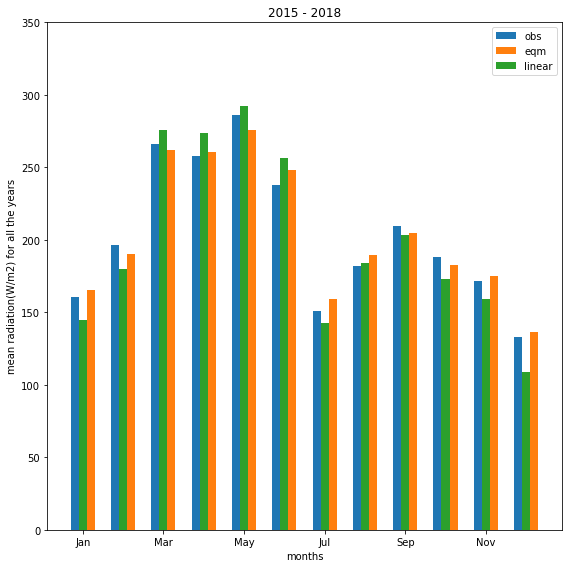

In [91]:
#intermediate conditions
bar(meanrad['meaninter1obs'],meanrad['meaninter1eqm'],meanrad['meaninter1lin'],'mean radiation(W/m2) for all the years',350, '2015 - 2018')

In [92]:
#cloudy conditions
bar(meanrad['meancloudy1obs'],meanrad['meancloudy1eqm'],meanrad['meancloudy1lin'],'mean radiation(W/m2) for all the years', 350)

TypeError: bar() missing 1 required positional argument: 'title'